**Цель проекта**

Нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения.

Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.

## Подключение библиотек и загрузка данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import torch
import torch.nn as nn
from math import ceil

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

from catboost import CatBoostClassifier

from torchmetrics import F1Score
from skorch import NeuralNetBinaryClassifier

In [ ]:
torch.manual_seed(987)
np.random.seed(987)

In [ ]:
sns.set()

Загрузим таблицу collisions.

In [ ]:
collisions = pd.read_csv('/content/drive/MyDrive/integrated 3/collisions_all.csv')

In [ ]:
collisions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 20 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   case_id                      1400000 non-null  int64  
 1   county_city_location         1400000 non-null  int64  
 2   county_location              1400000 non-null  object 
 3   distance                     1400000 non-null  float64
 4   direction                    1059358 non-null  object 
 5   intersection                 1387781 non-null  float64
 6   weather_1                    1392741 non-null  object 
 7   location_type                518779 non-null   object 
 8   collision_damage             1400000 non-null  object 
 9   party_count                  1400000 non-null  int64  
 10  primary_collision_factor     1391834 non-null  object 
 11  pcf_violation_category       1372046 non-null  object 
 12  type_of_collision            1388176 non-n

В таблице имеется информация об 1.4 миллиона ДТП.

В некоторых столбцах есть пропуски.

In [ ]:
collisions.head()

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0.0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,NaN,1.0,clear,NaN,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,109,alameda,0.0,NaN,1.0,clear,NaN,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,109,alameda,0.0,NaN,1.0,clear,NaN,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,NaN,1.0,clear,NaN,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,NaN,dark with street lights,functioning,2009-01-02,22:43:00


In [ ]:
collisions.describe()

,case_id,county_city_location,distance,intersection,party_count
count,1.400000e+06,1.400000e+06,1.400000e+06,1.387781e+06,1.400000e+06
mean,4.872952e+06,2.790996e+03,6.607115e+02,2.249087e-01,1.966006e+00
std,4.562559e+05,1.322919e+03,1.178579e+04,4.175223e-01,6.724457e-01
min,8.171500e+04,1.000000e+02,0.000000e+00,0.000000e+00,1.000000e+00
25%,4.475734e+06,1.942000e+03,2.000000e+00,0.000000e+00,2.000000e+00
50%,4.887088e+06,3.001000e+03,1.000000e+02,0.000000e+00,2.000000e+00
75%,5.266762e+06,3.705000e+03,4.300000e+02,0.000000e+00,2.000000e+00
max,5.668369e+06,5.802000e+03,8.363520e+06,1.000000e+00,2.700000e+01


Загрузим таблицу parties.

In [ ]:
parties = pd.read_csv('/content/drive/MyDrive/integrated 3/parties.csv')

In [ ]:
parties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2752408 entries, 0 to 2752407
Data columns (total 9 columns):
 #   Column               Dtype  
---  ------               -----  
 0   id                   int64  
 1   case_id              int64  
 2   party_number         int64  
 3   party_type           object 
 4   at_fault             int64  
 5   insurance_premium    float64
 6   party_sobriety       object 
 7   party_drug_physical  object 
 8   cellphone_in_use     float64
dtypes: float64(2), int64(4), object(3)
memory usage: 189.0+ MB


Таблица содержит 2.75 миллиона записей об участниках ДТП.

В некоторых столбцах содержатся пропуски.

In [ ]:
parties.head()

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,NaN,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,NaN,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,NaN,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,NaN,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0


In [ ]:
parties.describe()

,id,case_id,party_number,at_fault,insurance_premium,cellphone_in_use
count,2.752408e+06,2.752408e+06,2.752408e+06,2.752408e+06,2.347006e+06,2.240771e+06
mean,1.376204e+06,4.873980e+06,1.598029e+00,4.680000e-01,3.874724e+01,2.045055e-02
std,7.945519e+05,4.560005e+05,7.236567e-01,4.989750e-01,1.637851e+01,1.415356e-01
min,1.000000e+00,8.171500e+04,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.881028e+05,4.476559e+06,1.000000e+00,0.000000e+00,2.500000e+01,0.000000e+00
50%,1.376204e+06,4.888276e+06,1.000000e+00,0.000000e+00,3.600000e+01,0.000000e+00
75%,2.064306e+06,5.268235e+06,2.000000e+00,1.000000e+00,5.000000e+01,0.000000e+00
max,2.752408e+06,5.668369e+06,2.700000e+01,1.000000e+00,1.050000e+02,1.000000e+00


Загрузим таблицу vehicles.

In [ ]:
vehicles = pd.read_csv('/content/drive/MyDrive/integrated 3/vehicles.csv')

In [ ]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021234 entries, 0 to 1021233
Data columns (total 6 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1021234 non-null  int64  
 1   case_id               1021234 non-null  int64  
 2   party_number          1021234 non-null  int64  
 3   vehicle_type          1021234 non-null  object 
 4   vehicle_transmission  997575 non-null   object 
 5   vehicle_age           996652 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 46.7+ MB


В таблице содержится около 1 миллиона записей о транспортных средствах, попадавших в ДТП.

Два столбца имеют пропуски.

In [ ]:
vehicles.head()

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3.0
1,1,3858022,1,sedan,auto,3.0
2,1175712,5305030,1,sedan,auto,3.0
3,1175717,5305033,3,sedan,auto,5.0
4,1175722,5305034,2,sedan,auto,5.0


In [ ]:
vehicles.describe()

,id,case_id,party_number,vehicle_age
count,1.021234e+06,1.021234e+06,1.021234e+06,996652.000000
mean,7.601628e+05,4.878369e+06,1.609510e+00,5.137088
std,4.386194e+05,4.562607e+05,6.790946e-01,3.110310
min,1.000000e+00,3.858022e+06,1.000000e+00,0.000000
25%,3.806942e+05,4.478837e+06,1.000000e+00,3.000000
50%,7.617625e+05,4.891940e+06,2.000000e+00,5.000000
75%,1.141348e+06,5.272816e+06,2.000000e+00,7.000000
max,1.517654e+06,5.668360e+06,2.700000e+01,161.000000


Соединим три таблицы.

Для этого сначала присоединим таблицу parties к collisions по столбцу case_id, а затем к получившейся таблице присоединим таблицу vehicles по столбцам case_id и party_number.

In [ ]:
data = collisions.merge(parties, on='case_id', how='left')
data = data.merge(vehicles, on=['case_id', 'party_number'], how='left', suffixes=('_parties', '_vehicles'))

Для построения модели будем использовать только данные за 2012 год, исключив тип повреждений "SCRATCH", с типом виновника "car".

In [ ]:
data = data[data['collision_date'].apply(lambda x: '2012' in x)]
data = data[data['collision_damage'] != 'scratch']
data = data[data['case_id'].isin(data.loc[(data['at_fault'] == 1) & (data['party_type'] == 'car'), 'case_id'])]

data = data.reset_index(drop=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198481 entries, 0 to 198480
Data columns (total 32 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   case_id                      198481 non-null  int64  
 1   county_city_location         198481 non-null  int64  
 2   county_location              198481 non-null  object 
 3   distance                     198481 non-null  float64
 4   direction                    157360 non-null  object 
 5   intersection                 197424 non-null  float64
 6   weather_1                    197925 non-null  object 
 7   location_type                83178 non-null   object 
 8   collision_damage             198481 non-null  object 
 9   party_count                  198481 non-null  int64  
 10  primary_collision_factor     198481 non-null  object 
 11  pcf_violation_category       195542 non-null  object 
 12  type_of_collision            197051 non-null  object 
 13 

## Предобработка и EDA.

Разделим датасет на обучающую и тестовую выборки в соотношении 80:20.

Таргетом является столбец at_fault.

In [ ]:
data, data_test = train_test_split(data, test_size=0.2, stratify=data['at_fault'], random_state=987)

Проведем предобработку обучающей выборки.

Столбцы id, county_city_location можно удалить, так как они не несут никакой информации.

In [ ]:
data = data.drop(columns=['county_city_location', 'case_id', 'id_parties', 'id_vehicles', 'party_number'], axis=1)

Для более удобных названий переименуем некоторые столбцы.

In [ ]:
data = data.rename(columns={'weather_1': 'weather', 'road_condition_1': 'road_condition'})

In [ ]:
data.duplicated().sum()

1971

В данных есть дубликаты, от них необходимо избавиться.

In [ ]:
data = data.drop_duplicates(ignore_index=True)

In [ ]:
data.isna().sum()

county_location                     0
distance                            0
direction                       32729
intersection                      805
weather                           413
location_type                   90455
collision_damage                    0
party_count                         0
primary_collision_factor            0
pcf_violation_category           2289
type_of_collision                1139
motor_vehicle_involved_with       613
road_surface                      947
road_condition                    798
lighting                          492
control_device                    716
collision_date                      0
collision_time                   1451
party_type                         74
at_fault                            0
insurance_premium               24708
party_sobriety                   3877
party_drug_physical            130285
cellphone_in_use                23950
vehicle_type                   112456
vehicle_transmission           113121
vehicle_age 

В некоторых столбцах есть немного выбросов, а в некоторых - очень много. Удалить лучше только те пропуски, которых не так много, не более чем 5% от всего датасета

In [ ]:
data = data.dropna(subset=['intersection', 'weather', 'pcf_violation_category', 'type_of_collision', 'motor_vehicle_involved_with', 'road_surface', 'road_condition', 'lighting', 'control_device', 'collision_time', 'party_type', 'party_sobriety'])

Столбцы direction, location_type, insurance_premium, party_drug_physical, cellphone_in_use, vehicle_type, vehicle_transmission, vehicle_age содержат много пропусков. Из-за этого их нельзя удалить. Пропуски в категориальных столбцах заполним значением unknown, а в количественных - медианой.

In [ ]:
data[['direction', 'location_type', 'party_drug_physical', 'cellphone_in_use', 'vehicle_type', 'vehicle_transmission']] = data[['direction', 'location_type', 'party_drug_physical', 'cellphone_in_use', 'vehicle_type', 'vehicle_transmission']].fillna('unknown')
data['insurance_premium'] = data['insurance_premium'].fillna(data['insurance_premium'].median())
data['vehicle_age'] = data['vehicle_age'].fillna(data['vehicle_age'].median())

<ipython-input-27-0cd7cfd728ae>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[['direction', 'location_type', 'party_drug_physical', 'cellphone_in_use', 'vehicle_type', 'vehicle_transmission']] = data[['direction', 'location_type', 'party_drug_physical', 'cellphone_in_use', 'vehicle_type', 'vehicle_transmission']].fillna('unknown')


Приведем столбцы intersection, cellphone_in_use к строковому типу, так как несмотря на то, что они численные, они являются категориальными.

In [ ]:
data['intersection'] = data['intersection'].astype('object')

In [ ]:
data['cellphone_in_use'] = data['cellphone_in_use'].astype('string').astype('object')

Столбцы insurance_premium, vehicle_age можно привести к целочисленному типу.

In [ ]:
data['insurance_premium'] = data['insurance_premium'].astype('int')

In [ ]:
data['vehicle_age'] = data['vehicle_age'].astype('int')

Из даты и времени для нас будут информативны только месяц и час, в которые случилось происшествие. Создадим столбцы с этими значениями, удалив старые.

In [ ]:
data['collision_date'] = pd.to_datetime(data['collision_date'], format='%Y-%m-%d')
data['collision_time'] = pd.to_datetime(data['collision_time'], format='%H:%M:%S')

In [ ]:
data['collision_month'] = data['collision_date'].dt.month
data['collision_hour'] = data['collision_time'].dt.hour

In [ ]:
data = data.drop(columns=['collision_date', 'collision_time'], axis=1)

Проведем исследовательский анализ данных.

In [ ]:
data['county_location'].value_counts()

los angeles        47983
orange             13654
san bernardino      8137
riverside           7751
san diego           7487
alameda             6280
sacramento          5503
santa clara         5119
ventura             3777
kern                3216
contra costa        3103
san mateo           2904
san joaquin         2191
tulare              2093
fresno              2087
santa barbara       1934
sonoma              1786
stanislaus          1779
monterey            1608
placer              1427
san francisco       1310
solano              1302
san luis obispo     1153
marin               1132
santa cruz          1124
merced               923
yolo                 811
humboldt             731
el dorado            593
butte                592
madera               577
shasta               533
napa                 480
kings                432
nevada               391
mendocino            387
imperial             364
tehama               280
sutter               276
tuolumne             209


Возьмем топ-30 локаций, а остальным присвоим категорию other.

In [ ]:
top_30_locations = data['county_location'].value_counts().index[:30]

In [ ]:
data.loc[~data['county_location'].isin(top_30_locations), 'county_location'] = 'other'

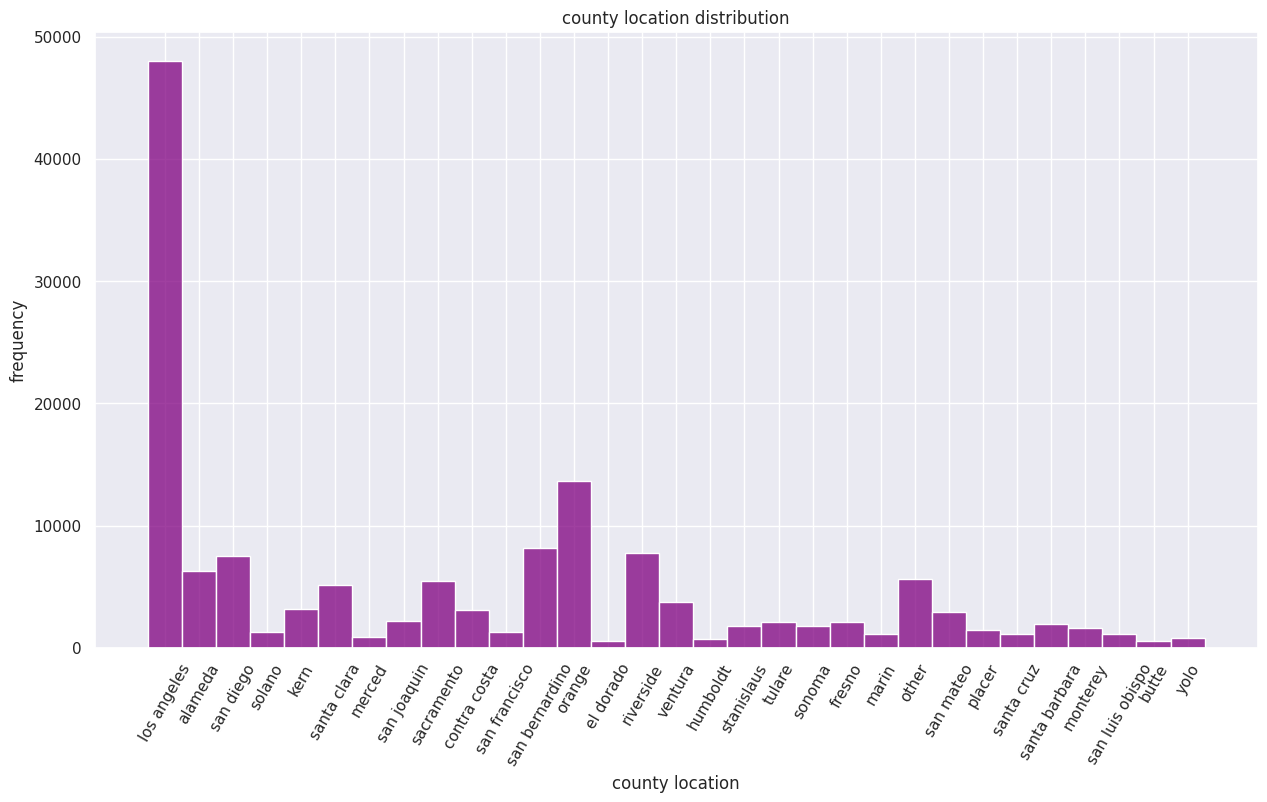

In [ ]:
fig, ax_hist = plt.subplots(1, sharex=True, figsize=(15, 8))

sns.histplot(x=data['county_location'], ax=ax_hist, color='purple')

ax_hist.set(xlabel='county location')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='county location distribution')
ax_hist.tick_params(axis='x', rotation=60)
plt.show()

Большинство информации о ДТП было собрано в Лос-Анджелесе.

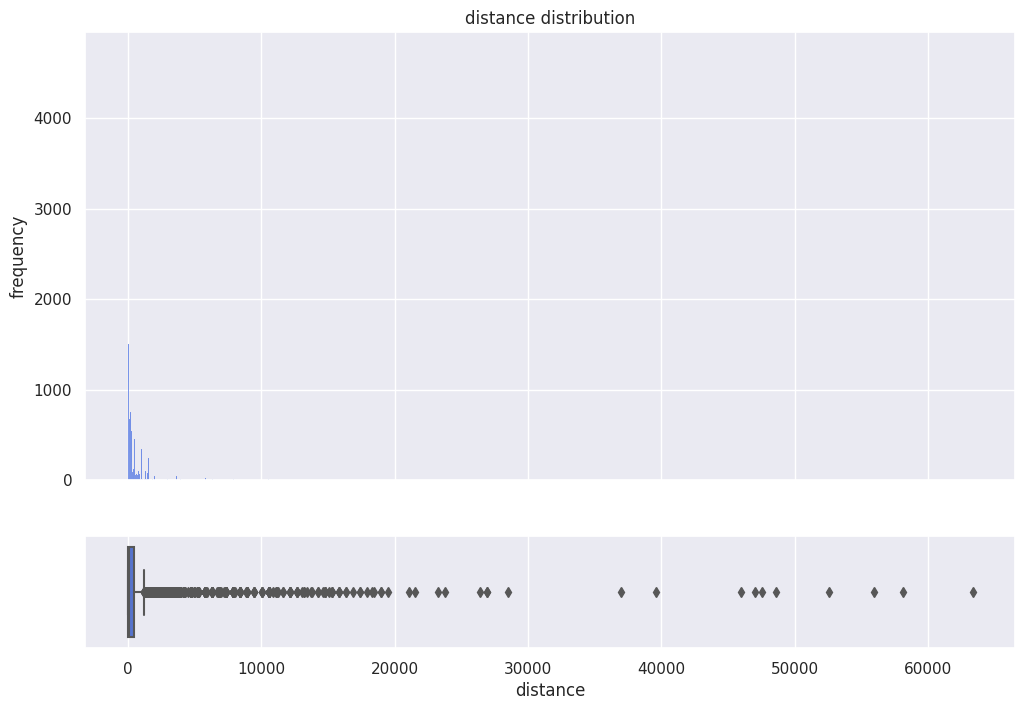

In [ ]:
fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.8, .2)}, figsize=(12, 8))

sns.histplot(x=data.loc[::10, 'distance'], ax=ax_hist, color='royalblue')
sns.boxplot(x=data.loc[::10, 'distance'], ax=ax_box, color='royalblue')

ax_box.set(xlabel='distance')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='distance distribution')
plt.show()

In [ ]:
data.loc[data['distance'] > 1000, 'distance'].count()

21105

Выбросов в столбце не так много, можно их удалить.

In [ ]:
data = data[data['distance'] <= 1000]

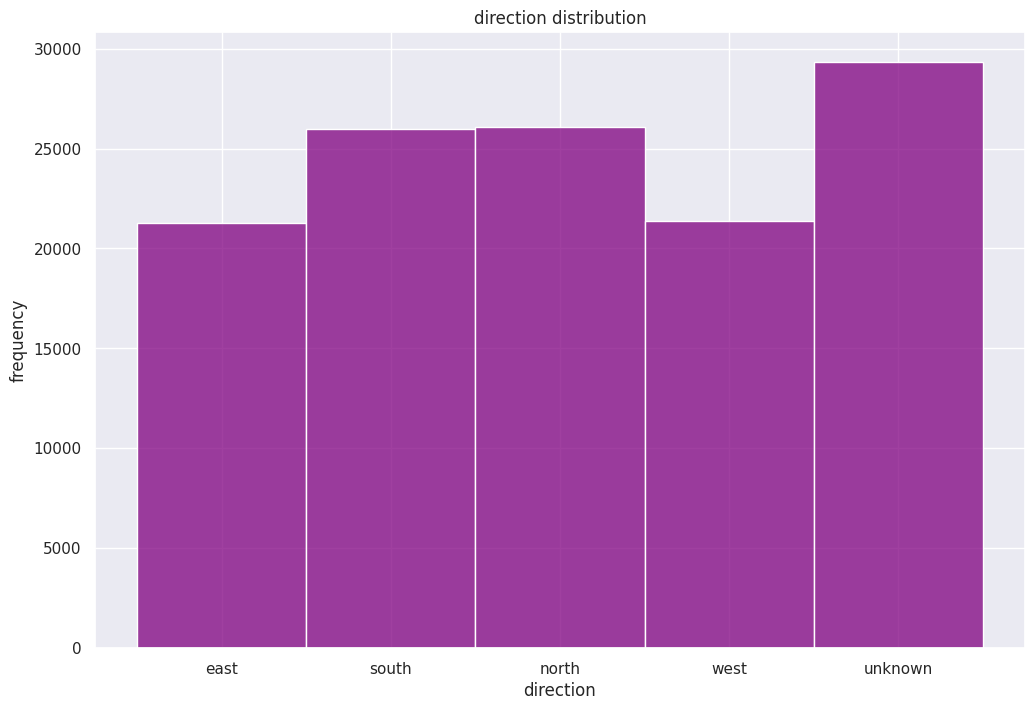

In [ ]:
fig, ax_hist = plt.subplots(1, sharex=True, figsize=(12, 8))

sns.histplot(x=data['direction'], ax=ax_hist, color='purple')

ax_hist.set(xlabel='direction')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='direction distribution')
plt.show()

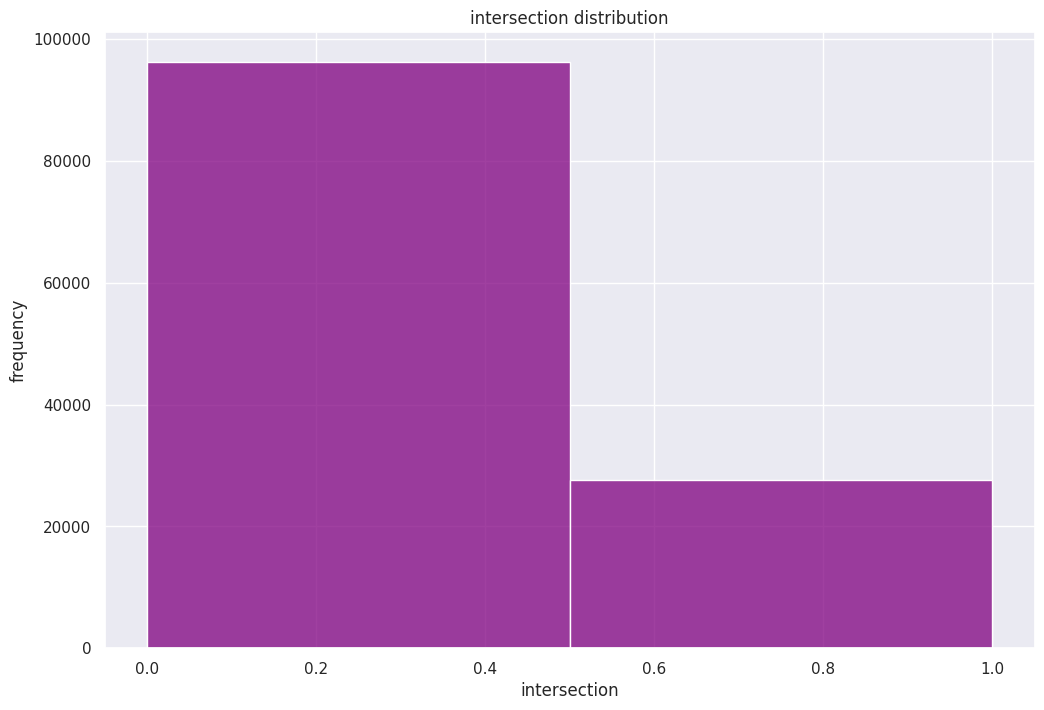

In [ ]:
fig, ax_hist = plt.subplots(1, sharex=True, figsize=(12, 8))

sns.histplot(x=data['intersection'], ax=ax_hist, color='purple', bins=2)

ax_hist.set(xlabel='intersection')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='intersection distribution')
plt.show()

Большая часть происшествий произошло не на перекрестке.

In [ ]:
data['weather'].value_counts()

clear      99998
cloudy     18225
raining     5196
fog          347
snowing      163
other         54
wind          25
Name: weather, dtype: int64

Категоризируем столбец, отнеся все значения, кроме clear, cloudy и raining к категории other.

In [ ]:
top_3_weather = data['weather'].value_counts()[:3].index

In [ ]:
data.loc[~data['weather'].isin(top_3_weather), 'weather'] = 'other'

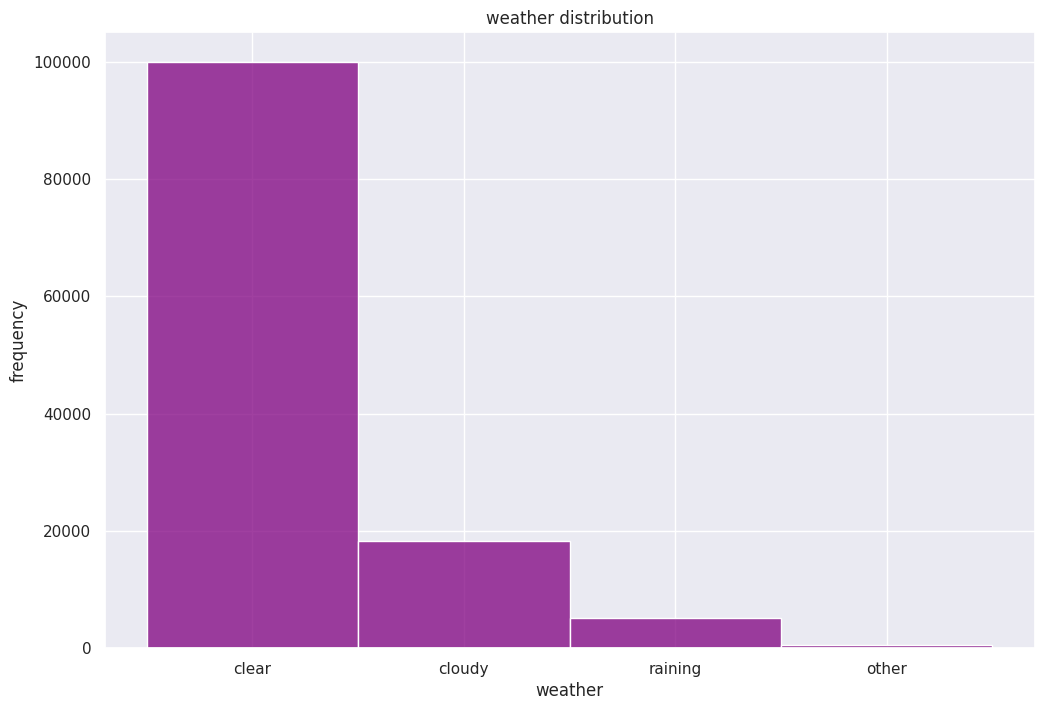

In [ ]:
fig, ax_hist = plt.subplots(1, sharex=True, figsize=(12, 8))

sns.histplot(x=data['weather'], ax=ax_hist, color='purple')

ax_hist.set(xlabel='weather')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='weather distribution')
plt.show()

Большинство ДТП произошло в ясную погоду.

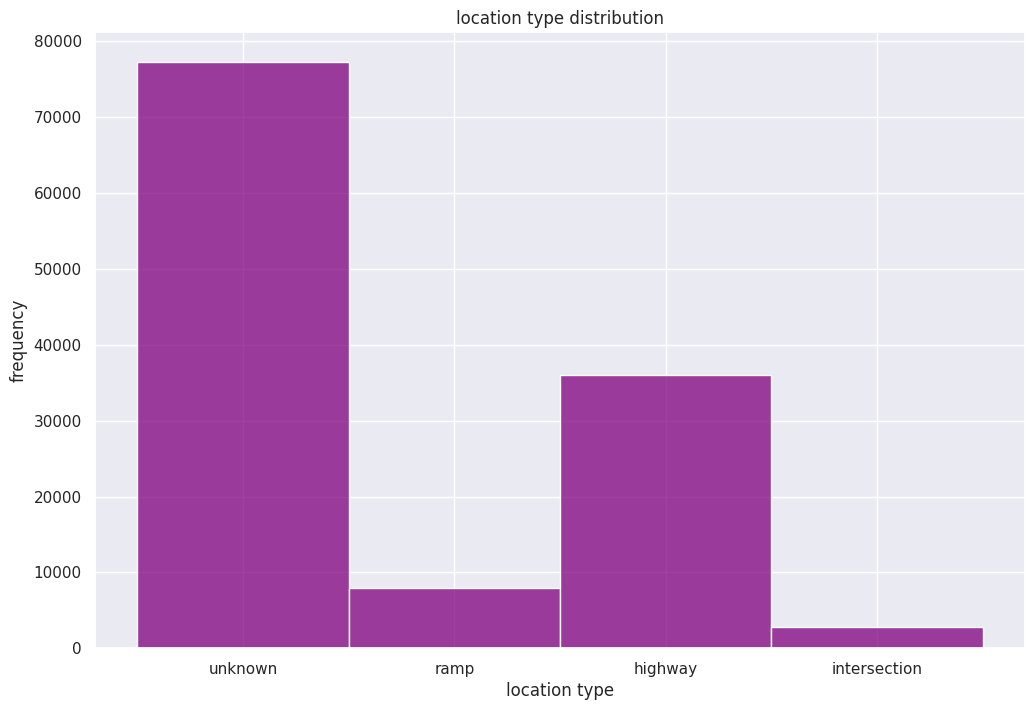

In [ ]:
fig, ax_hist = plt.subplots(1, sharex=True, figsize=(12, 8))

sns.histplot(x=data['location_type'], ax=ax_hist, color='purple')

ax_hist.set(xlabel='location type')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='location type distribution')
plt.show()

Большинство ДТП происходило либо на шоссе, либо тип местности неустановлен.

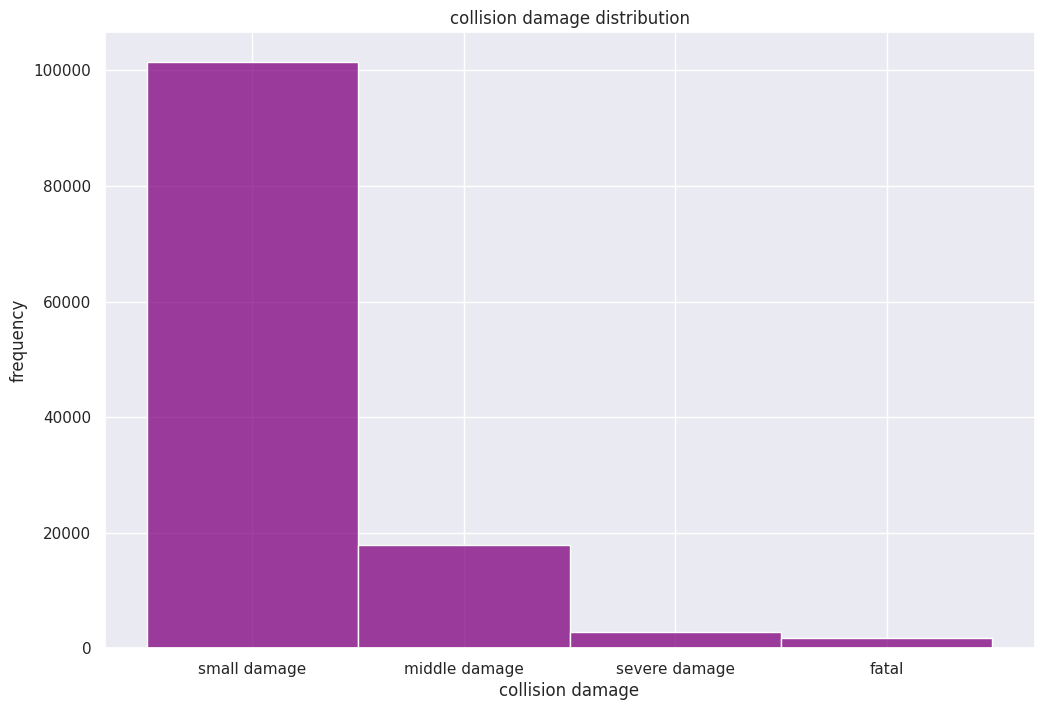

In [ ]:
fig, ax_hist = plt.subplots(1, sharex=True, figsize=(12, 8))

sns.histplot(x=data['collision_damage'], ax=ax_hist, color='purple')

ax_hist.set(xlabel='collision damage')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='collision damage distribution')
plt.show()

Большая часть транспортных средств в ДТП обошлась небольшими повреждениями.

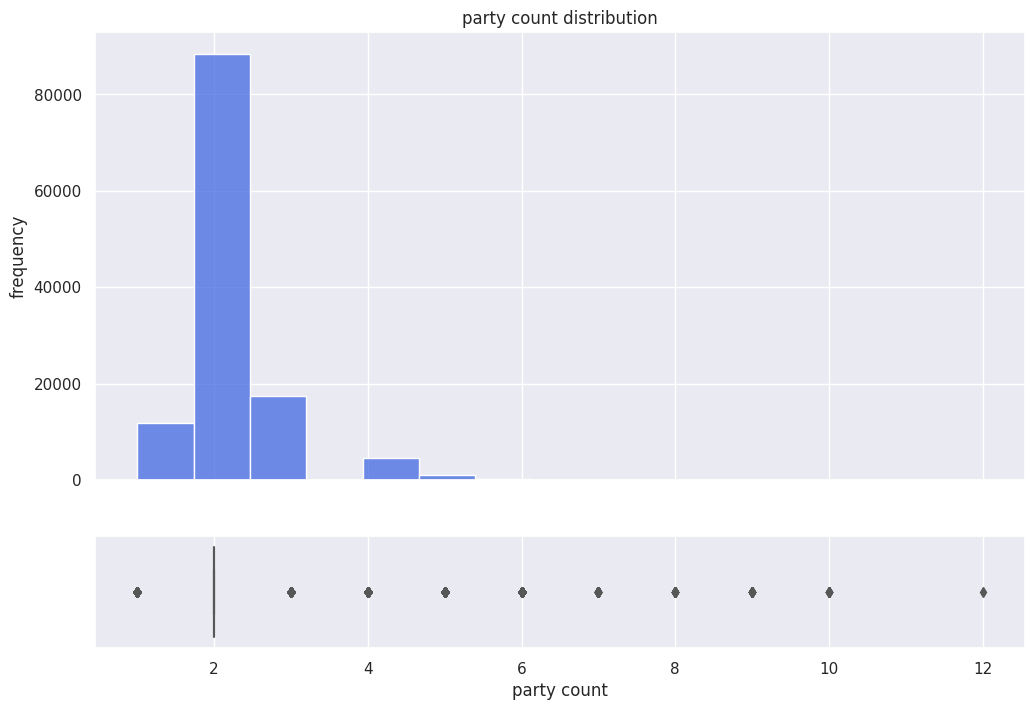

In [ ]:
fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.8, .2)}, figsize=(12, 8))

sns.histplot(x=data['party_count'], ax=ax_hist, color='royalblue', bins=15)
sns.boxplot(x=data['party_count'], ax=ax_box, color='royalblue')

ax_box.set(xlabel='party count')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='party count distribution')
plt.show()

In [ ]:
data.loc[data['party_count'] >= 5, 'party_count'].count()

1473

Выбросов столбец имеет немного, удалим их.

In [ ]:
data = data[data['party_count'] < 5]

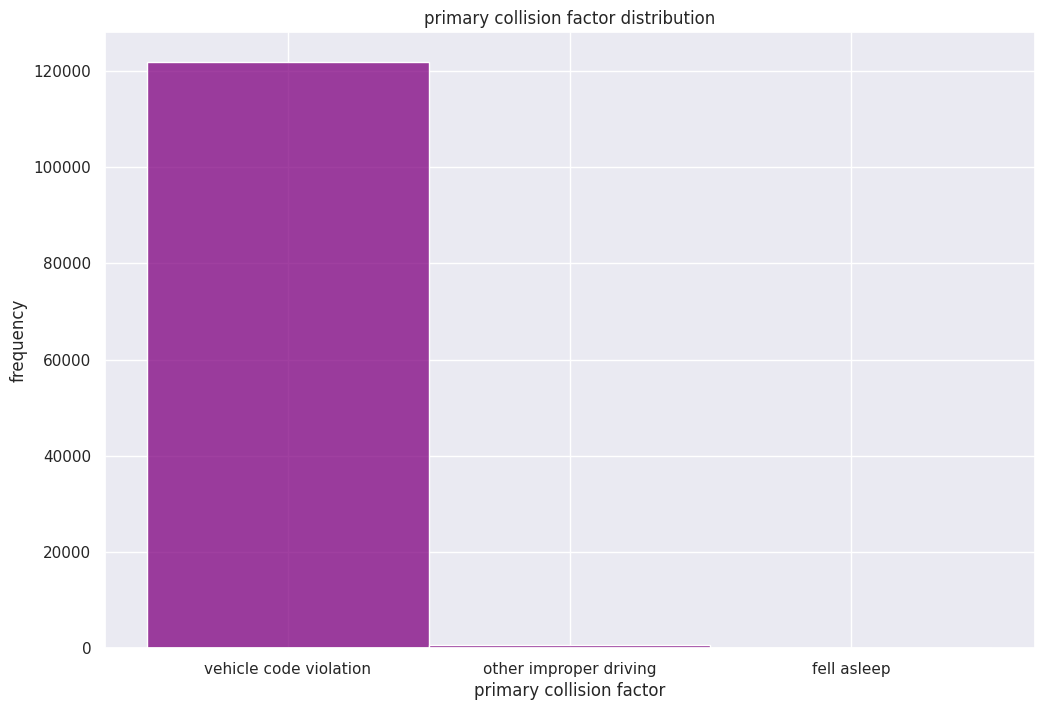

In [ ]:
fig, ax_hist = plt.subplots(1, sharex=True, figsize=(12, 8))

sns.histplot(x=data['primary_collision_factor'], ax=ax_hist, color='purple')

ax_hist.set(xlabel='primary collision factor')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='primary collision factor distribution')
plt.show()

In [ ]:
data['pcf_violation_category'].value_counts()

speeding                      44158
improper turning              19360
automobile right of way       15747
unsafe lane change            10526
dui                            9830
unsafe starting or backing     6467
traffic signals and signs      6456
following too closely          3035
wrong side of road             1992
improper passing               1324
pedestrian right of way        1298
other hazardous violation      1075
other improper driving          590
unknown                         203
other equipment                 148
hazardous parking               142
impeding traffic                102
pedestrian violation             60
brakes                           17
fell asleep                       3
lights                            2
Name: pcf_violation_category, dtype: int64

Категоризируем столбец pcf_violation_category. Редко встречающиеся категории отнесем к новой категории other.

In [ ]:
top_10_pcf_violation_category = data['pcf_violation_category'].value_counts()[:10].index

In [ ]:
data.loc[~data['pcf_violation_category'].isin(top_10_pcf_violation_category), 'pcf_violation_category'] = 'other'

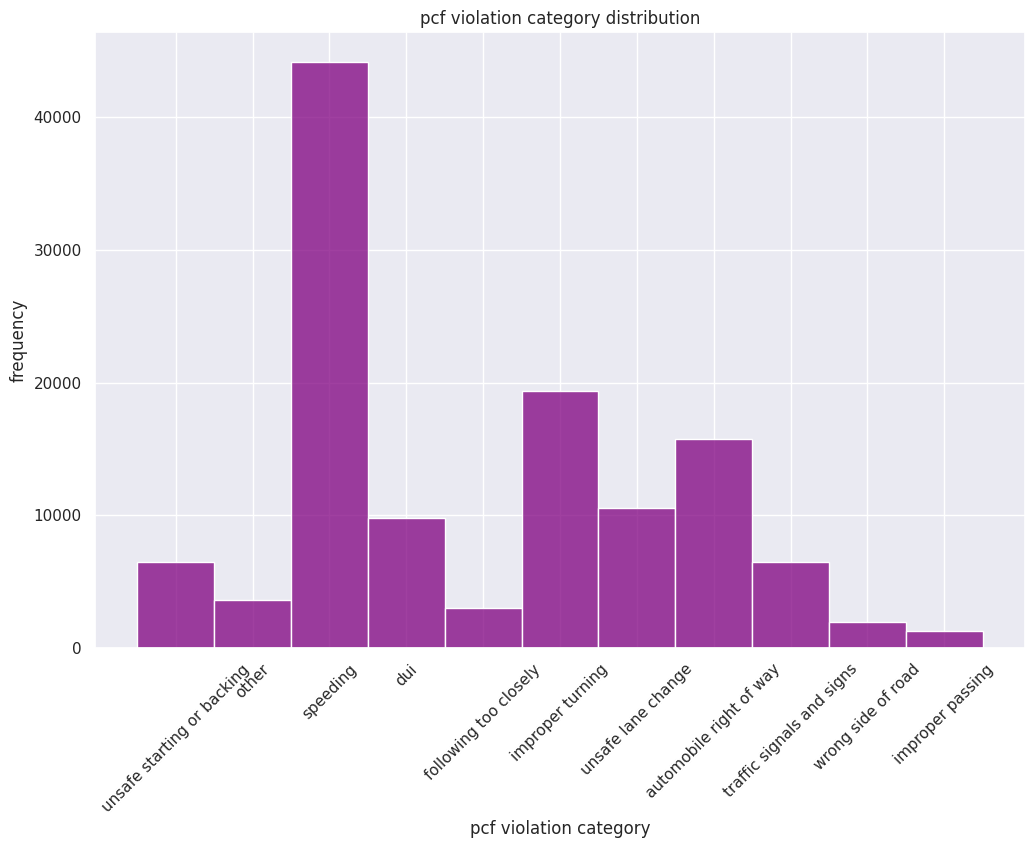

In [ ]:
fig, ax_hist = plt.subplots(1, sharex=True, figsize=(12, 8))

sns.histplot(x=data['pcf_violation_category'], ax=ax_hist, color='purple')

ax_hist.set(xlabel='pcf violation category')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='pcf violation category distribution')
ax_hist.tick_params(axis='x', rotation=45)
plt.show()

Большая часть аварий случилась из-за превышения скорости.

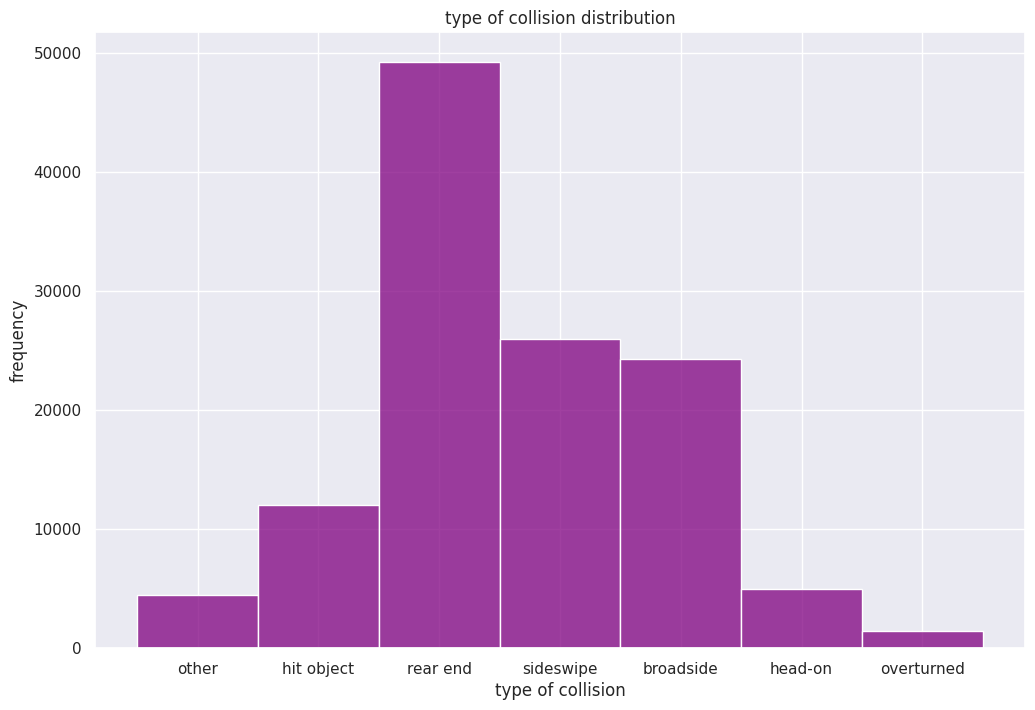

In [ ]:
fig, ax_hist = plt.subplots(1, sharex=True, figsize=(12, 8))

sns.histplot(x=data['type_of_collision'], ax=ax_hist, color='purple')

ax_hist.set(xlabel='type of collision')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='type of collision distribution')
plt.show()

In [ ]:
data['motor_vehicle_involved_with'].value_counts()

other motor vehicle               92001
fixed object                      11877
parked motor vehicle              11510
other object                       3253
non-collision                      1561
bicycle                            1427
motor vehicle on other roadway      859
animal                               28
train                                19
Name: motor_vehicle_involved_with, dtype: int64

Категоризируем столбец. Нечастым категориям присвоим категорию other.

In [ ]:
top_5_motor_vehicle_involved_with = data['motor_vehicle_involved_with'].value_counts()[:5].index

In [ ]:
data.loc[~data['motor_vehicle_involved_with'].isin(top_5_motor_vehicle_involved_with), 'motor_vehicle_involved_with'] = 'other'

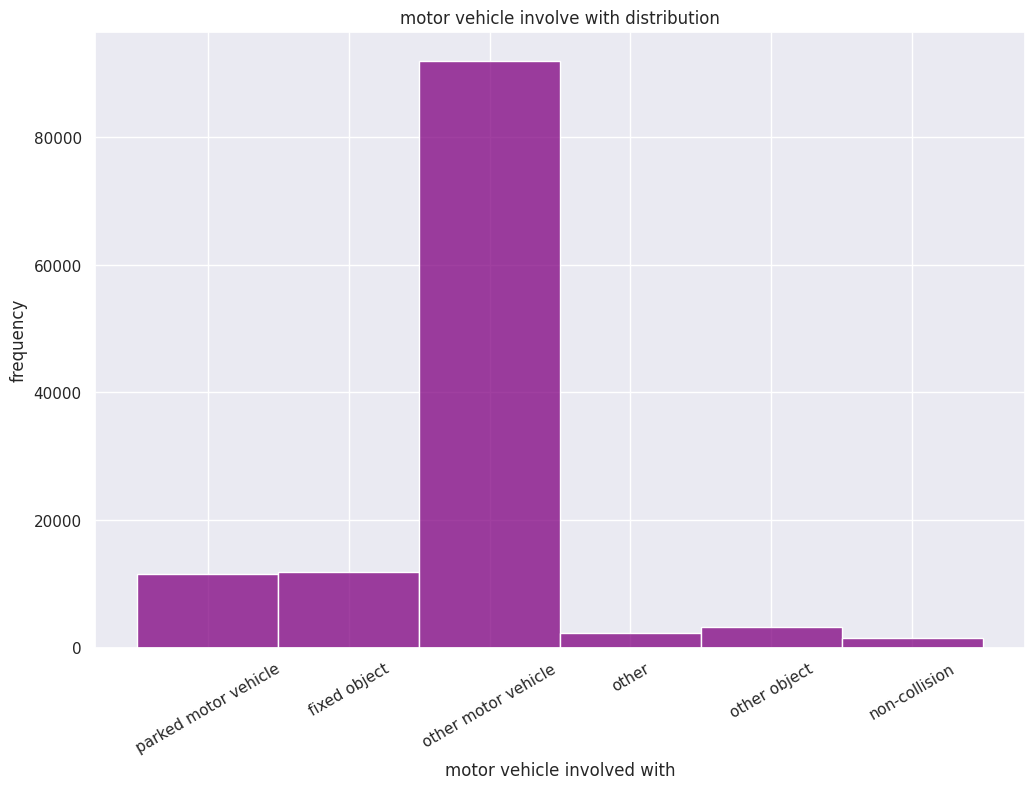

In [ ]:
fig, ax_hist = plt.subplots(1, sharex=True, figsize=(12, 8))

sns.histplot(x=data['motor_vehicle_involved_with'], ax=ax_hist, color='purple')

ax_hist.set(xlabel='motor vehicle involved with')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='motor vehicle involve with distribution')
ax_hist.tick_params(axis='x', rotation=30)
plt.show()

In [ ]:
data['road_surface'].value_counts()

dry         110460
wet          11667
snowy          341
slippery        67
Name: road_surface, dtype: int64

Отнесем редкие категории к other.

In [ ]:
top_2_road_surface = data['road_surface'].value_counts()[:2].index

In [ ]:
data.loc[~data['road_surface'].isin(top_2_road_surface), 'road_surface'] = 'other'

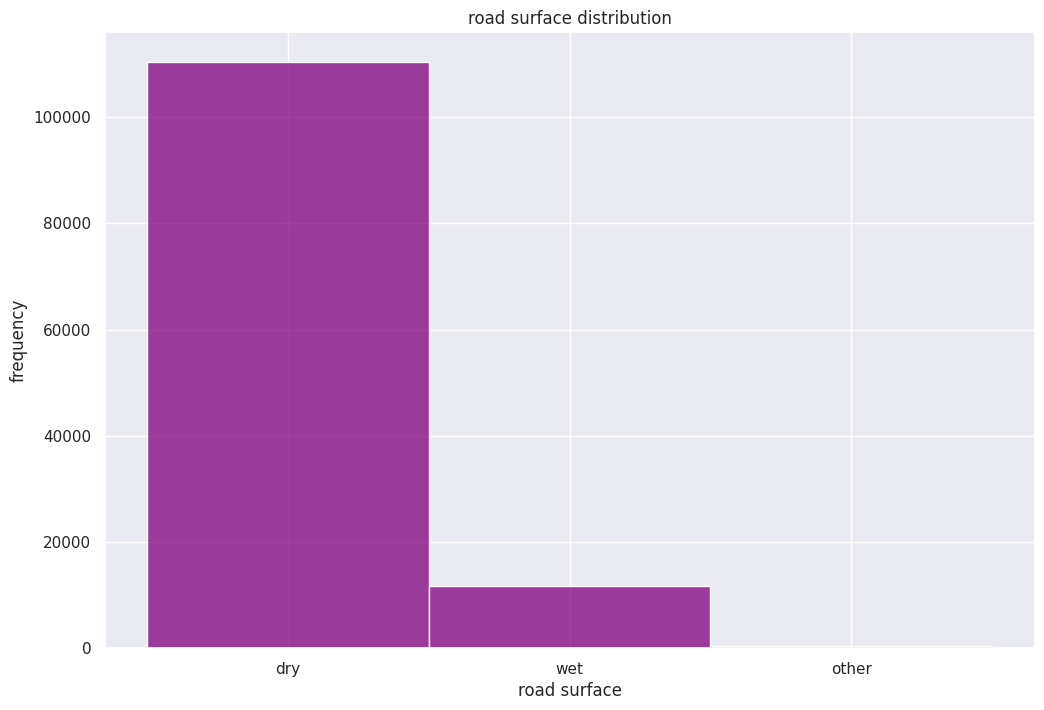

In [ ]:
fig, ax_hist = plt.subplots(1, sharex=True, figsize=(12, 8))

sns.histplot(x=data['road_surface'], ax=ax_hist, color='purple')

ax_hist.set(xlabel='road surface')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='road surface distribution')
plt.show()

Большинство ДТП произошло в сухую погоду.

In [ ]:
data['road_condition'].value_counts()

normal            119667
construction        1604
other                382
obstruction          315
holes                238
loose material       131
reduced width        129
flooded               69
Name: road_condition, dtype: int64

Отнесем все значения, кроме normal, к категории other.

In [ ]:
data.loc[data['road_condition'] != 'normal', 'road_condition'] = 'other'

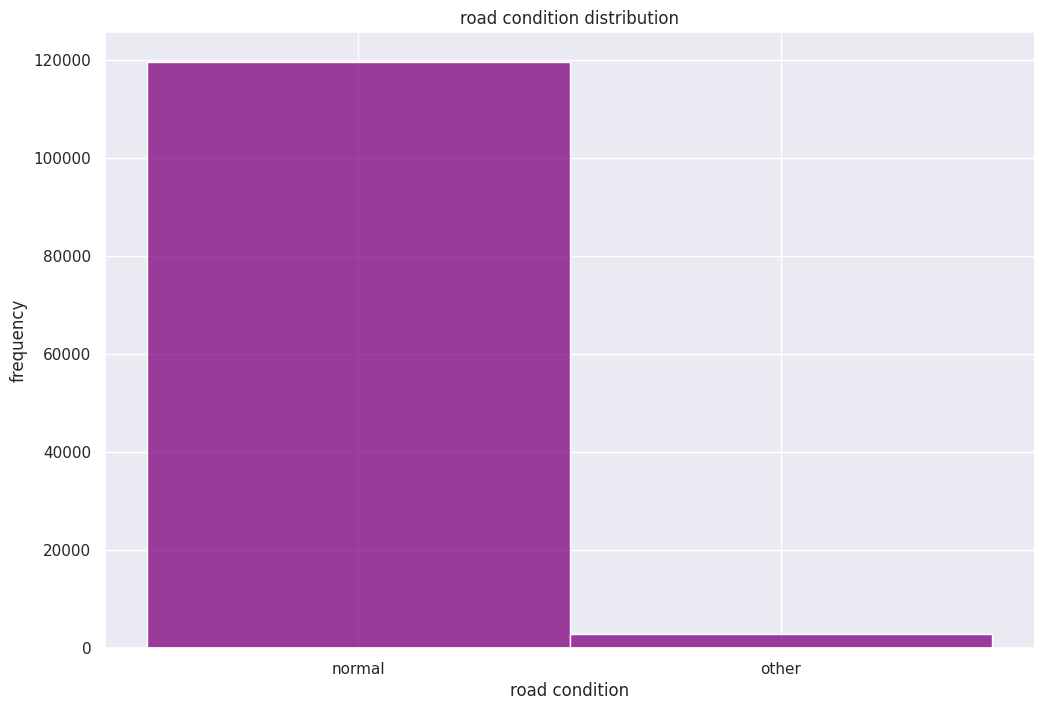

In [ ]:
fig, ax_hist = plt.subplots(1, sharex=True, figsize=(12, 8))

sns.histplot(x=data['road_condition'], ax=ax_hist, color='purple')

ax_hist.set(xlabel='road condition')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='road condition distribution')
plt.show()

In [ ]:
data['lighting'].value_counts()

daylight                                   84493
dark with street lights                    27218
dark with no street lights                  6506
dusk or dawn                                4044
dark with street lights not functioning      274
Name: lighting, dtype: int64

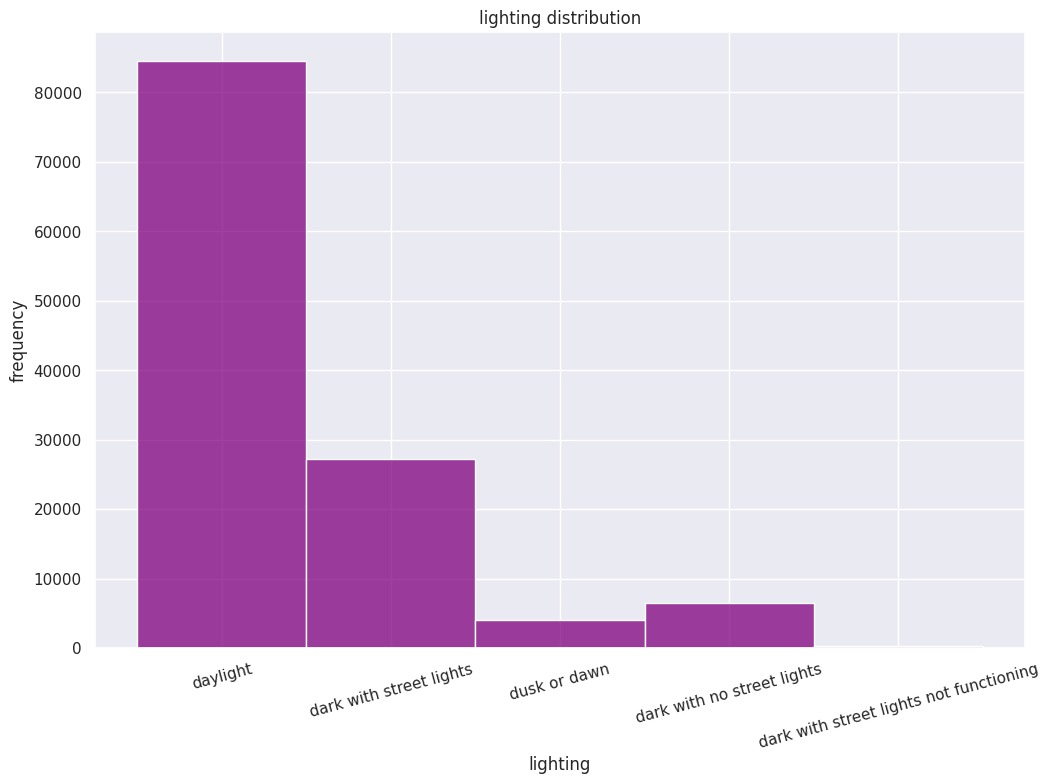

In [ ]:
fig, ax_hist = plt.subplots(1, sharex=True, figsize=(12, 8))

sns.histplot(x=data['lighting'], ax=ax_hist, color='purple')

ax_hist.set(xlabel='lighting')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='lighting distribution')
ax_hist.tick_params(axis='x', rotation=15)
plt.show()

Большинство ДТП произошло днем.

In [ ]:
data['control_device'].value_counts()

none               79018
functioning        43172
not functioning      275
obscured              70
Name: control_device, dtype: int64

Категоризируем столбец.

In [ ]:
top_2_control_device = data['control_device'].value_counts()[:2].index

In [ ]:
data.loc[~data['control_device'].isin(top_2_control_device), 'control_device'] = 'other'

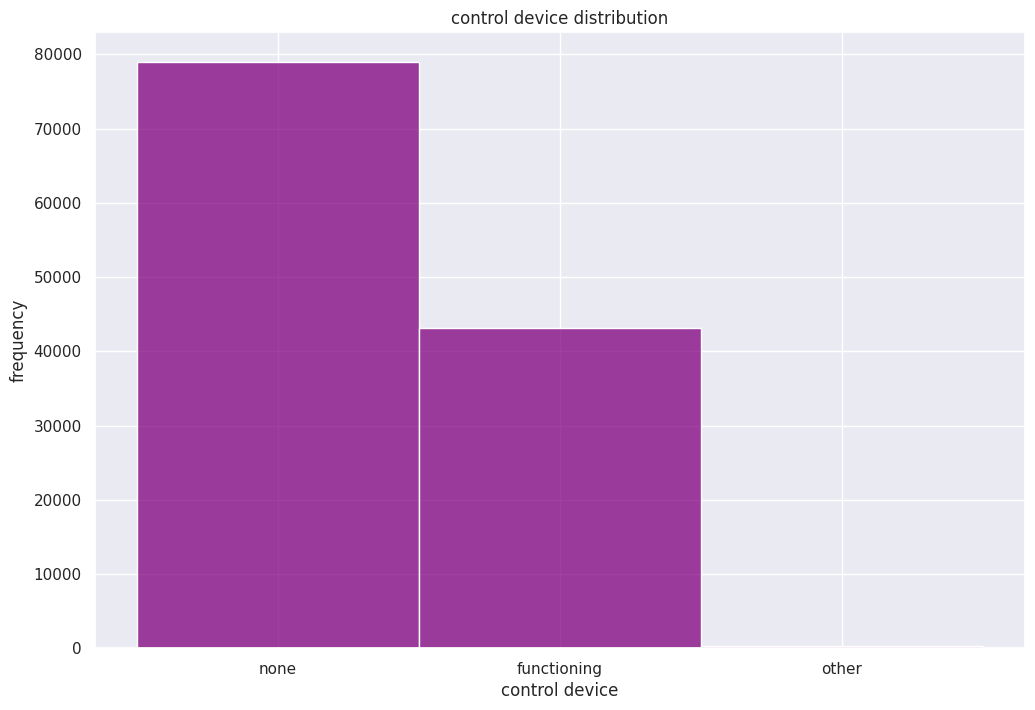

In [ ]:
fig, ax_hist = plt.subplots(1, sharex=True, figsize=(12, 8))

sns.histplot(x=data['control_device'], ax=ax_hist, color='purple')

ax_hist.set(xlabel='control device')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='control device distribution')
plt.show()

In [ ]:
data['party_type'].value_counts()

car            113478
road bumper      7070
road signs       1056
building          720
other             211
Name: party_type, dtype: int64

Категоризируем столбец.

In [ ]:
data.loc[data['party_type'] != 'car', 'party_type'] = 'other'

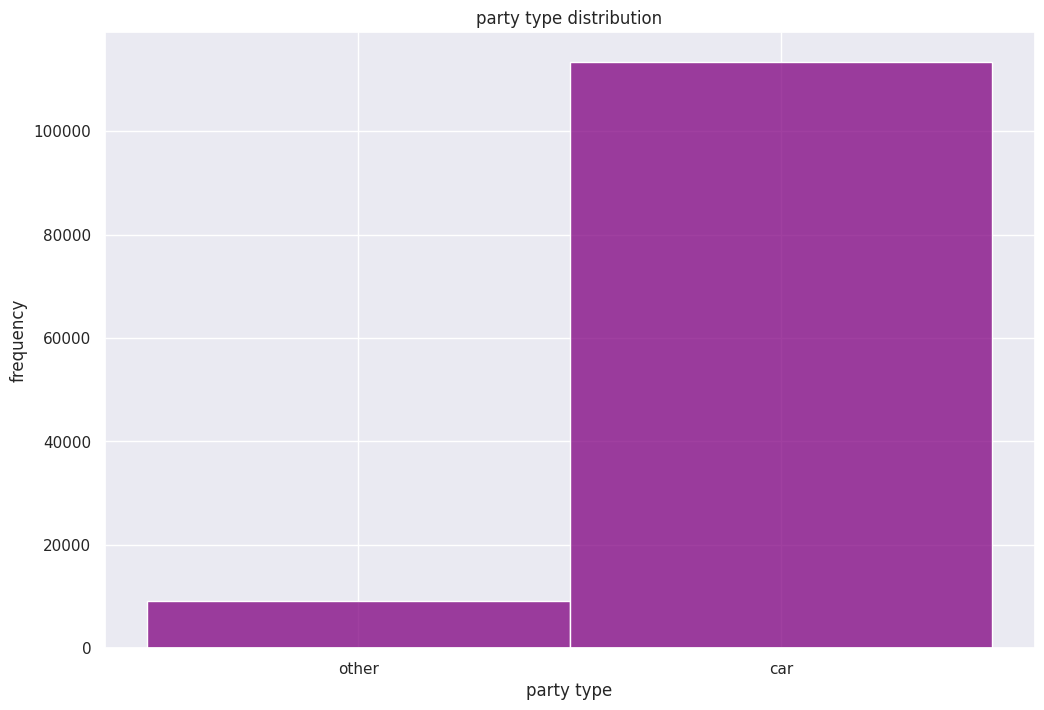

In [ ]:
fig, ax_hist = plt.subplots(1, sharex=True, figsize=(12, 8))

sns.histplot(x=data['party_type'], ax=ax_hist, color='purple')

ax_hist.set(xlabel='party type')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='party type distribution')
plt.show()

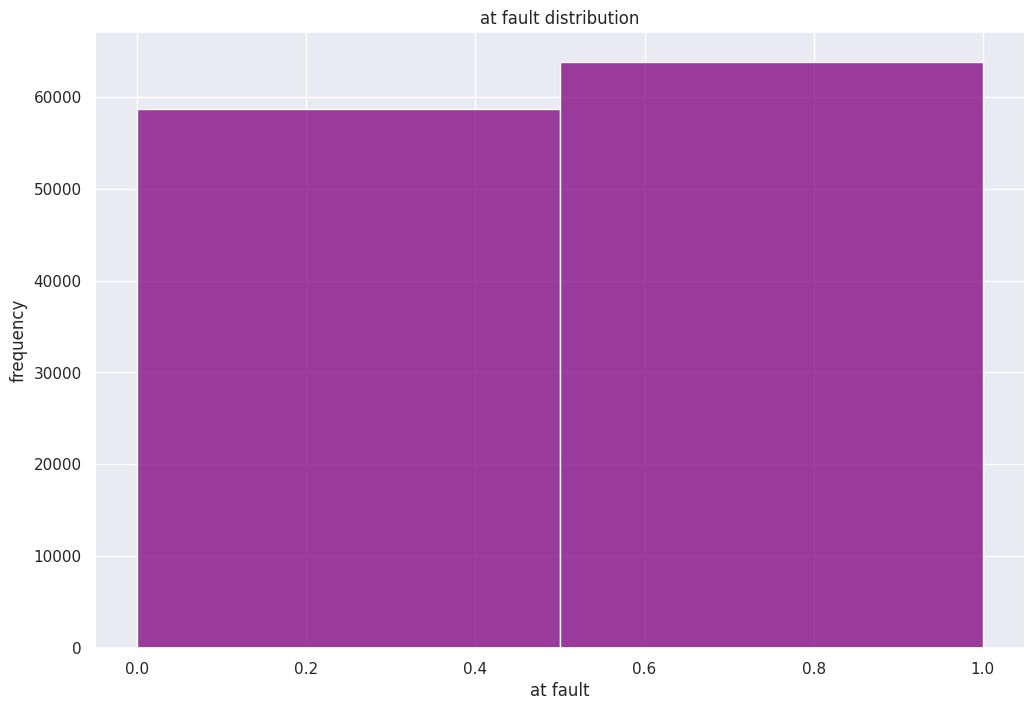

In [ ]:
fig, ax_hist = plt.subplots(1, sharex=True, figsize=(12, 8))

sns.histplot(x=data['at_fault'], ax=ax_hist, color='purple', bins=2)

ax_hist.set(xlabel='at fault')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='at fault distribution')
plt.show()

Таргет распределен почти равномерно.

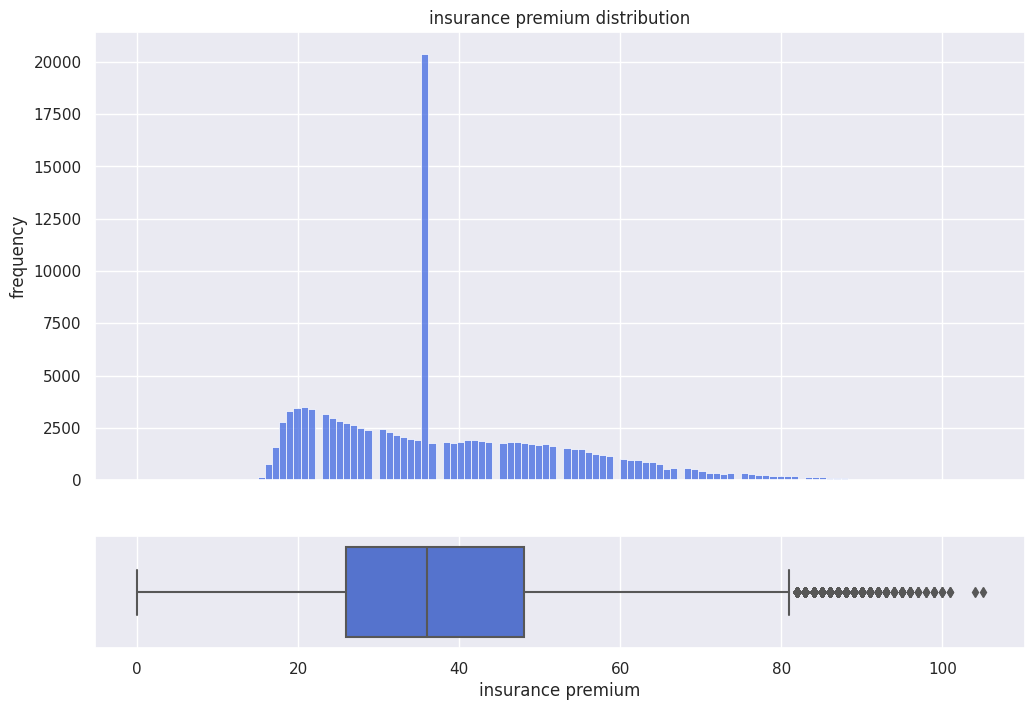

In [ ]:
fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.8, .2)}, figsize=(12, 8))

sns.histplot(x=data['insurance_premium'], ax=ax_hist, color='royalblue')
sns.boxplot(x=data['insurance_premium'], ax=ax_box, color='royalblue')

ax_box.set(xlabel='insurance premium')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='insurance premium distribution')
plt.show()

In [ ]:
data.loc[data['insurance_premium'] > 78, 'insurance_premium'].count()

1918

В столбце малое количество выбросов, можно их удалить.

In [ ]:
data = data[data['insurance_premium'] <= 78]

In [ ]:
data['party_sobriety'].value_counts()

had not been drinking                     92853
impairment unknown                        11911
not applicable                             7654
had been drinking, under influence         6409
had been drinking, impairment unknown      1000
had been drinking, not under influence      790
Name: party_sobriety, dtype: int64

Категоризируем данный столбец.

In [ ]:
top_4_party_sobriety = data['party_sobriety'].value_counts()[:4].index

In [ ]:
data.loc[~data['party_sobriety'].isin(top_4_party_sobriety), 'party_sobriety'] = 'other'

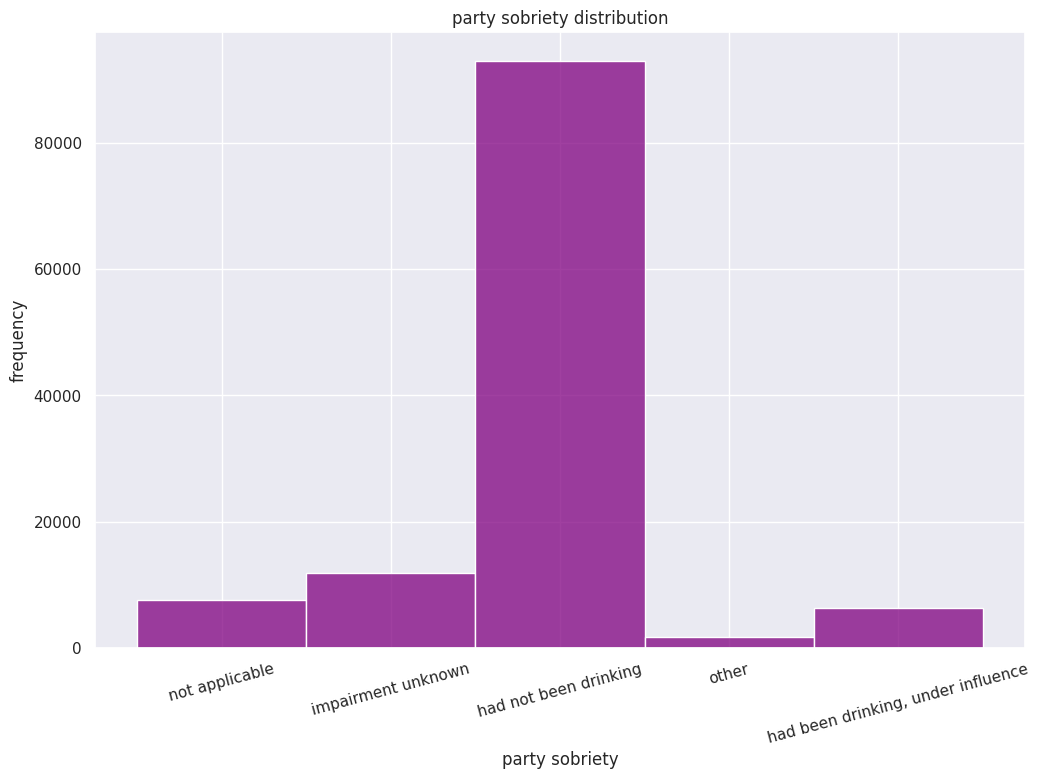

In [ ]:
fig, ax_hist = plt.subplots(1, sharex=True, figsize=(12, 8))

sns.histplot(x=data['party_sobriety'], ax=ax_hist, color='purple')

ax_hist.set(xlabel='party sobriety')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='party sobriety distribution')
ax_hist.tick_params(axis='x', rotation=15)
plt.show()

In [ ]:
data['party_drug_physical'].value_counts()

unknown                  100423
G                         11911
not applicable             7654
under drug influence        338
sleepy/fatigued             279
impairment - physical        12
Name: party_drug_physical, dtype: int64

Категоризируем столбец.

In [ ]:
top_3_party_drug_physical = data['party_drug_physical'].value_counts()[:3].index

In [ ]:
data.loc[~data['party_drug_physical'].isin(top_3_party_drug_physical), 'party_drug_physical'] = 'other'

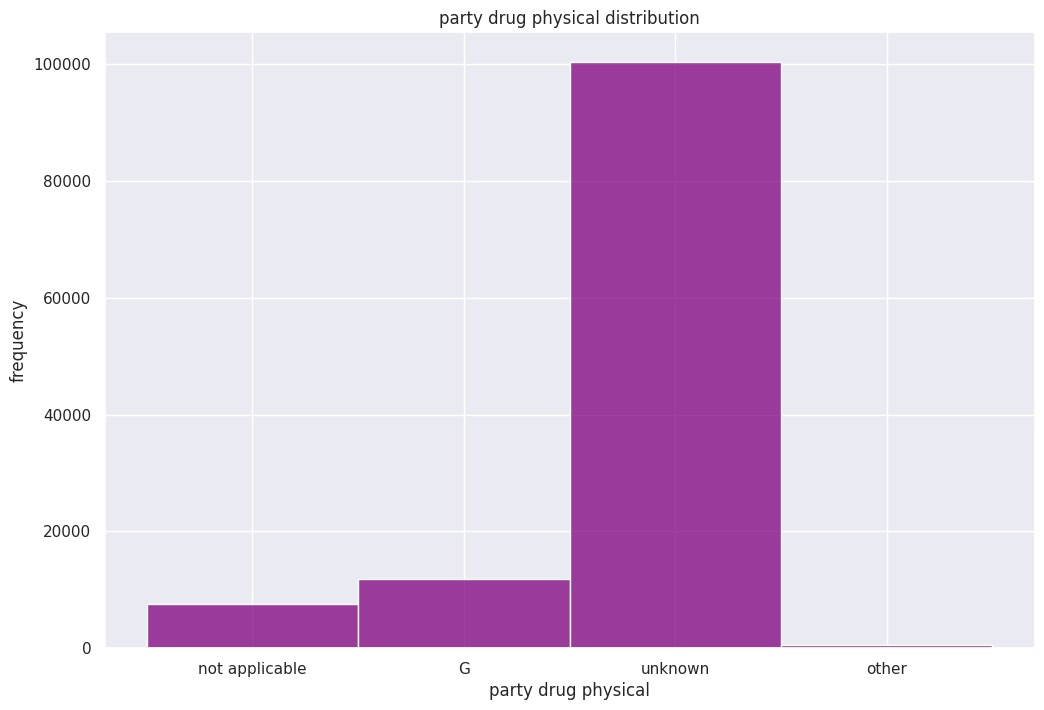

In [ ]:
fig, ax_hist = plt.subplots(1, sharex=True, figsize=(12, 8))

sns.histplot(x=data['party_drug_physical'], ax=ax_hist, color='purple')

ax_hist.set(xlabel='party drug physical')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='party drug physical distribution')
plt.show()

In [ ]:
data['cellphone_in_use'].value_counts()

0.0        99988
unknown    18232
1.0         2397
Name: cellphone_in_use, dtype: int64

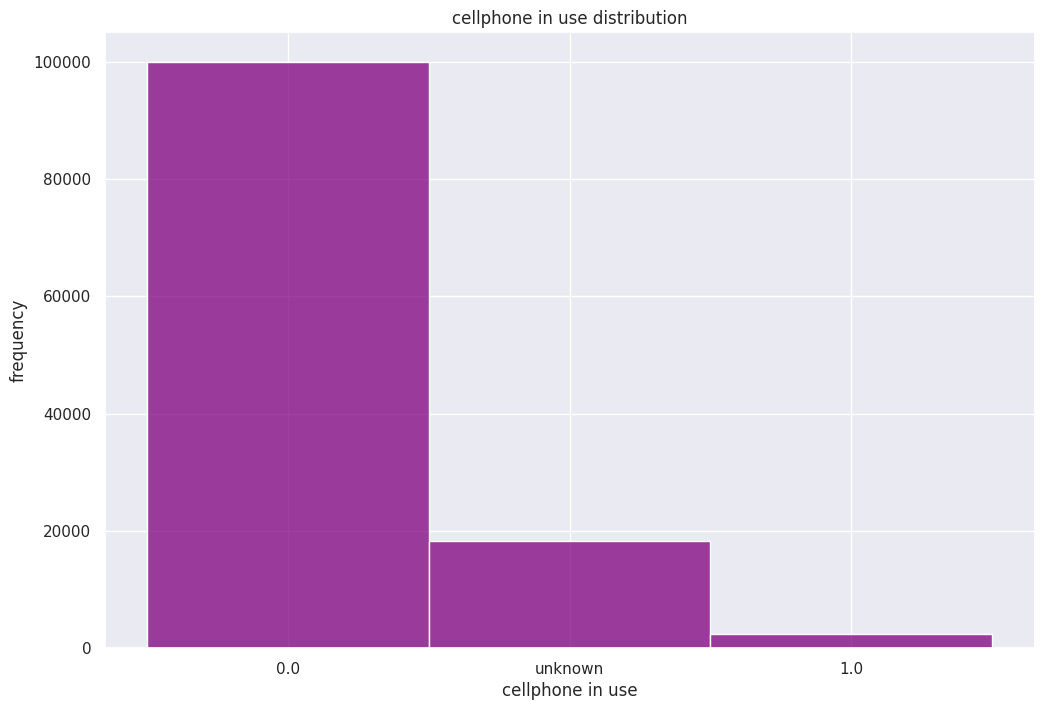

In [ ]:
fig, ax_hist = plt.subplots(1, sharex=True, figsize=(12, 8))

sns.histplot(x=data['cellphone_in_use'], ax=ax_hist, color='purple')

ax_hist.set(xlabel='cellphone in use')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='cellphone in use distribution')
plt.show()

In [ ]:
data['vehicle_type'].value_counts()

unknown      87337
sedan        21477
coupe        10223
hatchback      925
minivan        643
other           12
Name: vehicle_type, dtype: int64

Присвоим редким значениям категорию other.

In [ ]:
top_3_vehicle_type = data['vehicle_type'].value_counts()[:3].index

In [ ]:
data.loc[~data['vehicle_type'].isin(top_3_vehicle_type), 'vehicle_type'] = 'other'

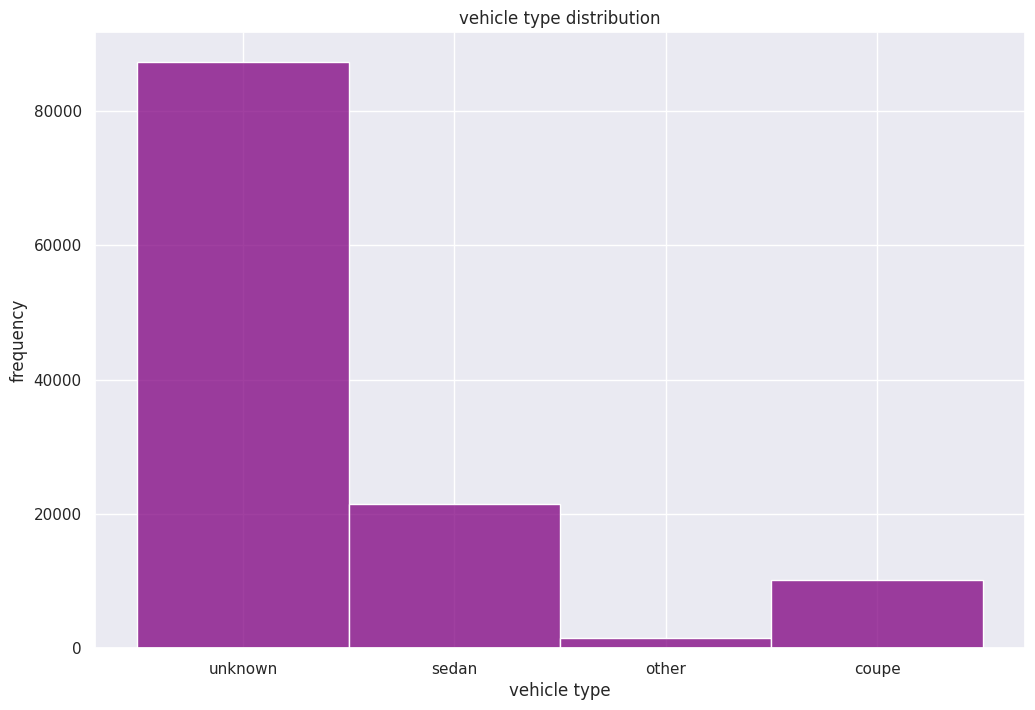

In [ ]:
fig, ax_hist = plt.subplots(1, sharex=True, figsize=(12, 8))

sns.histplot(x=data['vehicle_type'], ax=ax_hist, color='purple')

ax_hist.set(xlabel='vehicle type')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='vehicle type distribution')
plt.show()

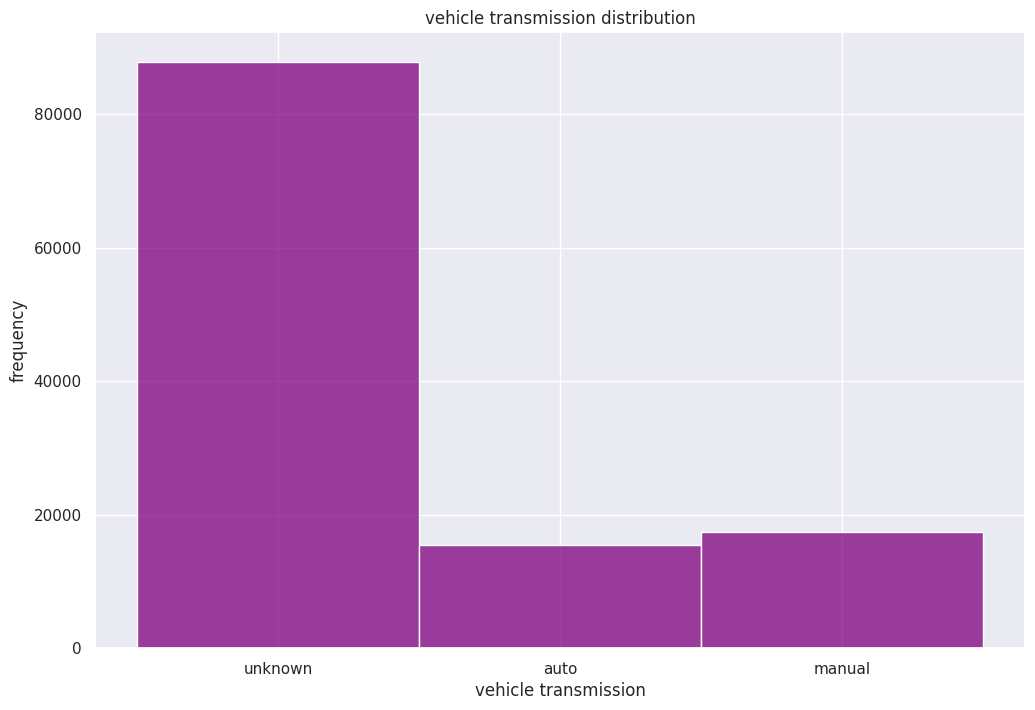

In [ ]:
fig, ax_hist = plt.subplots(1, sharex=True, figsize=(12, 8))

sns.histplot(x=data['vehicle_transmission'], ax=ax_hist, color='purple')

ax_hist.set(xlabel='vehicle transmission')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='vehicle transmission distribution')
plt.show()

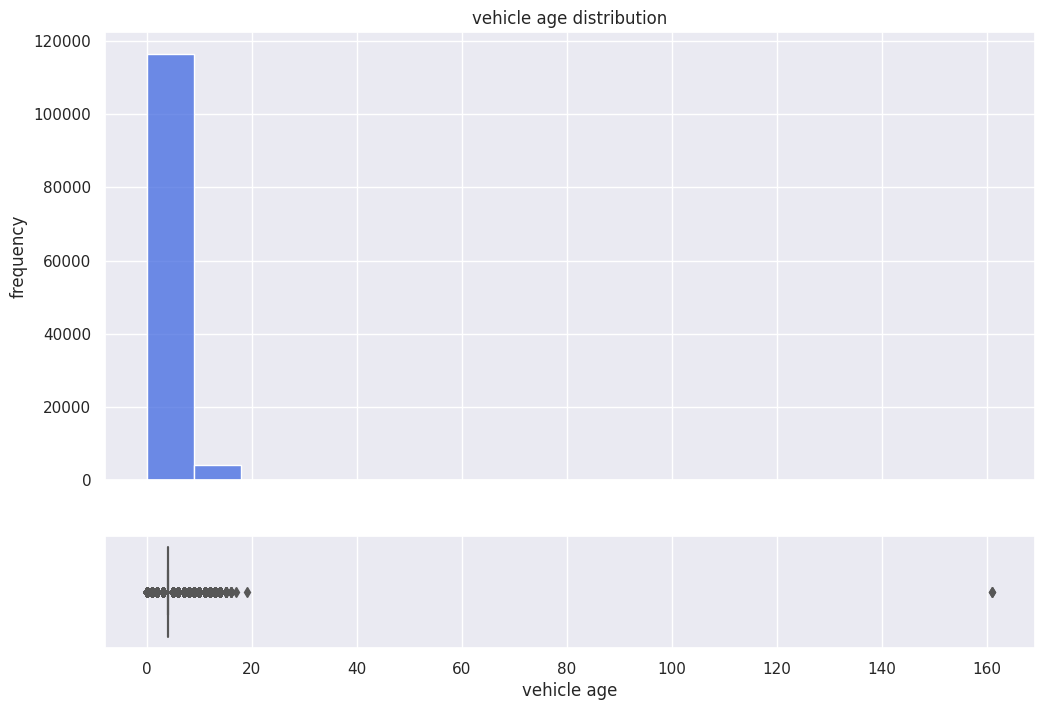

In [ ]:
fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.8, .2)}, figsize=(12, 8))

sns.histplot(x=data['vehicle_age'], ax=ax_hist, color='royalblue')
sns.boxplot(x=data['vehicle_age'], ax=ax_box, color='royalblue')

ax_box.set(xlabel='vehicle age')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='vehicle age distribution')
plt.show()

In [ ]:
data[data['vehicle_age'] > 10]['vehicle_age'].count()

1355

Удалим выбросы.

In [ ]:
data = data[data['vehicle_age'] <= 10]

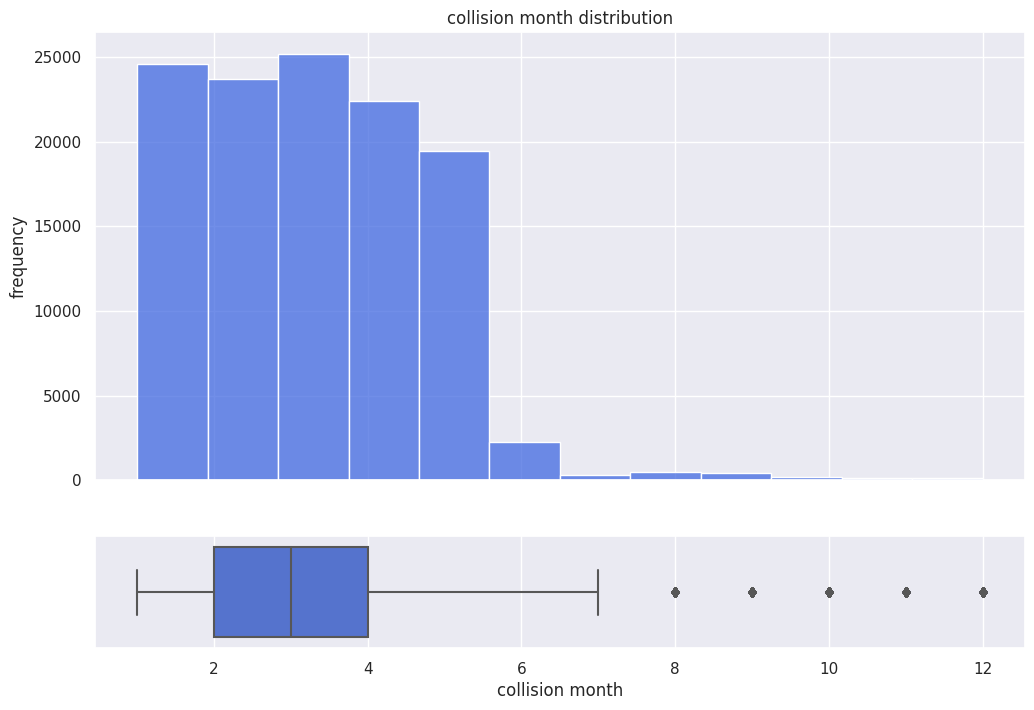

In [ ]:
fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.8, .2)}, figsize=(12, 8))

sns.histplot(x=data['collision_month'], ax=ax_hist, color='royalblue', bins=12)
sns.boxplot(x=data['collision_month'], ax=ax_box, color='royalblue')

ax_box.set(xlabel='collision month')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='collision month distribution')
plt.show()

Больше всего ДТП происходят в период с января по май, чаще всего они происходят в марте.

In [ ]:
data[data['collision_month'] > 7]['collision_month'].count()

1364

Удалим выбросы.

In [ ]:
data = data[data['collision_month'] <= 7]

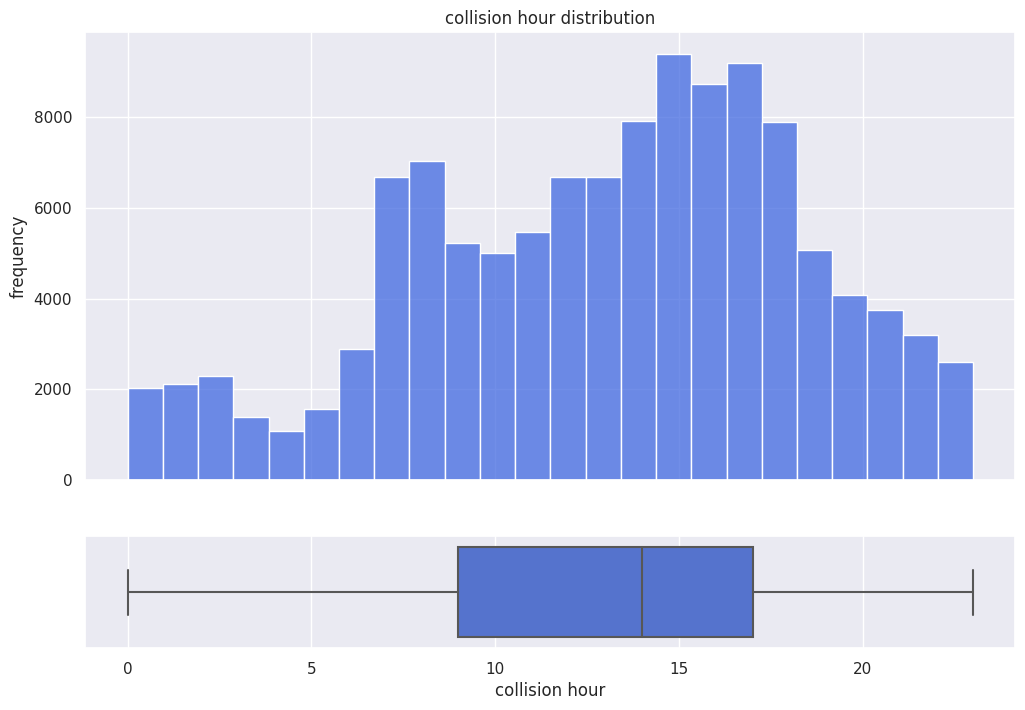

In [ ]:
fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.8, .2)}, figsize=(12, 8))

sns.histplot(x=data['collision_hour'], ax=ax_hist, color='royalblue', bins=24)
sns.boxplot(x=data['collision_hour'], ax=ax_box, color='royalblue')

ax_box.set(xlabel='collision hour')
ax_hist.set(ylabel='frequency')
ax_hist.set(title='collision hour distribution')
plt.show()

Пик происшествий приходится на 15 часов, меньше они случаются ночью.

In [ ]:
data = data.reset_index(drop=True)

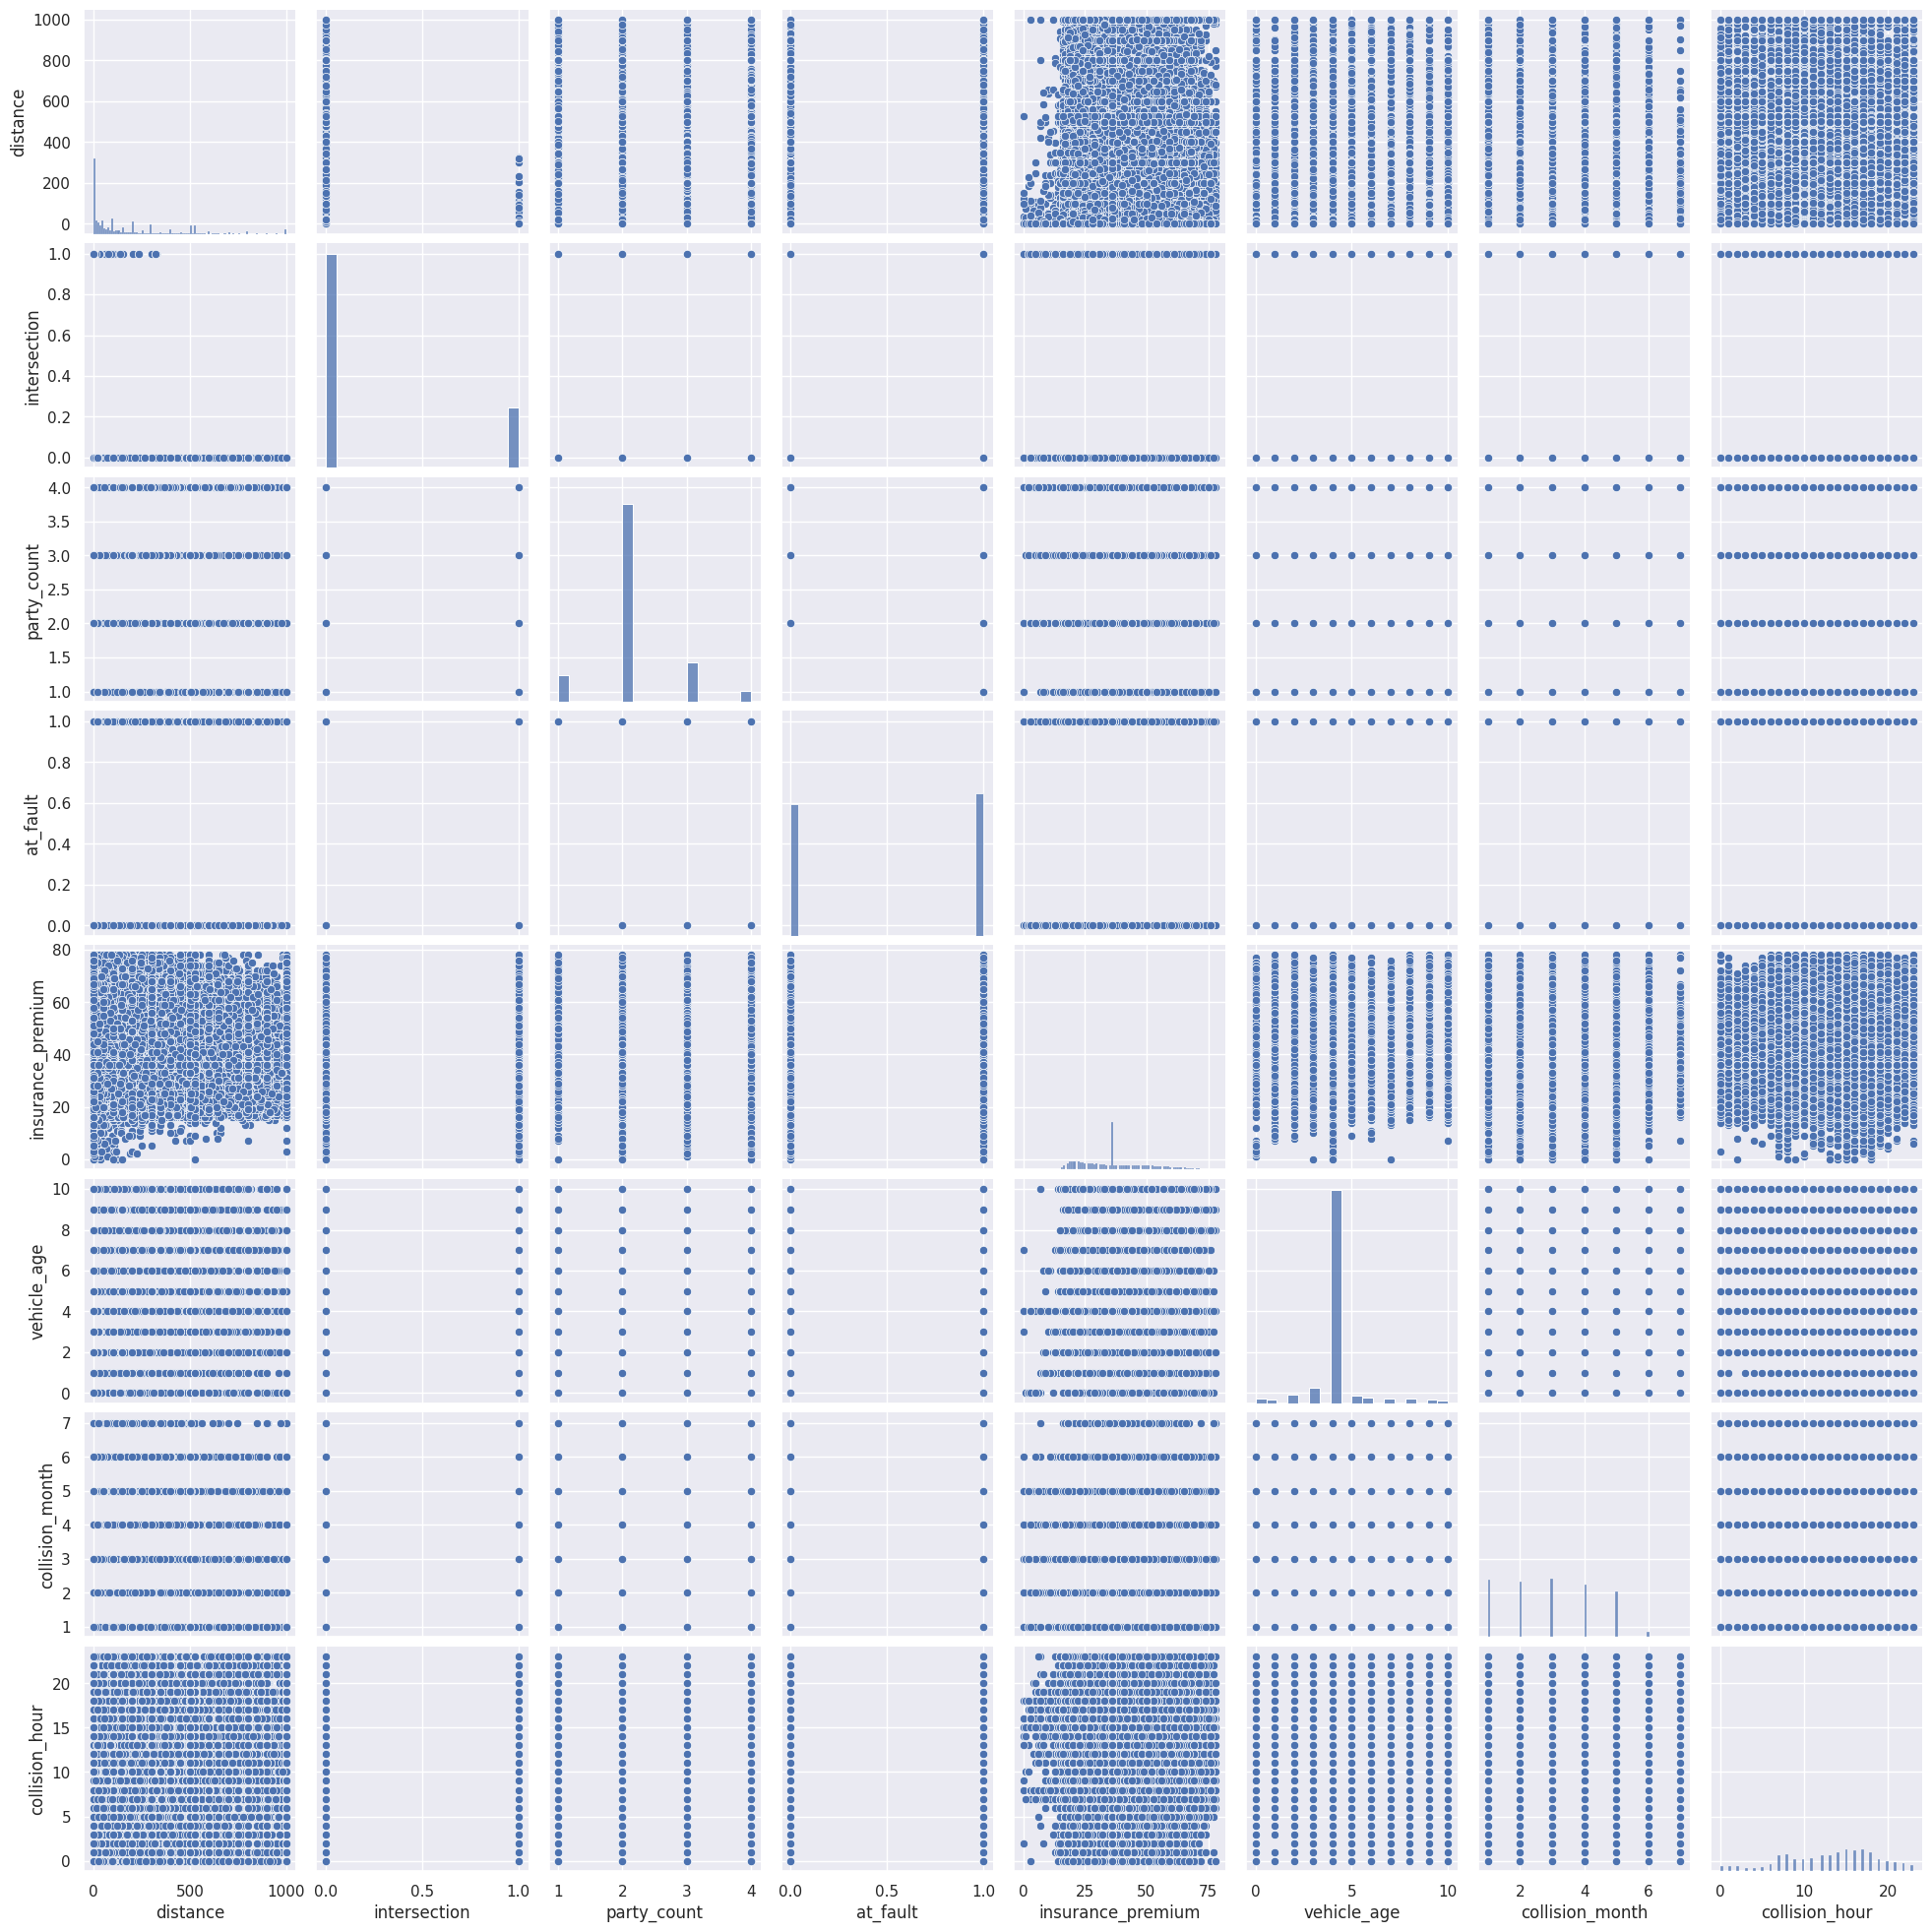

In [ ]:
sns.pairplot(data)

<ipython-input-107-3306b3393e27>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True, ax=ax, square=True)


<Axes: >

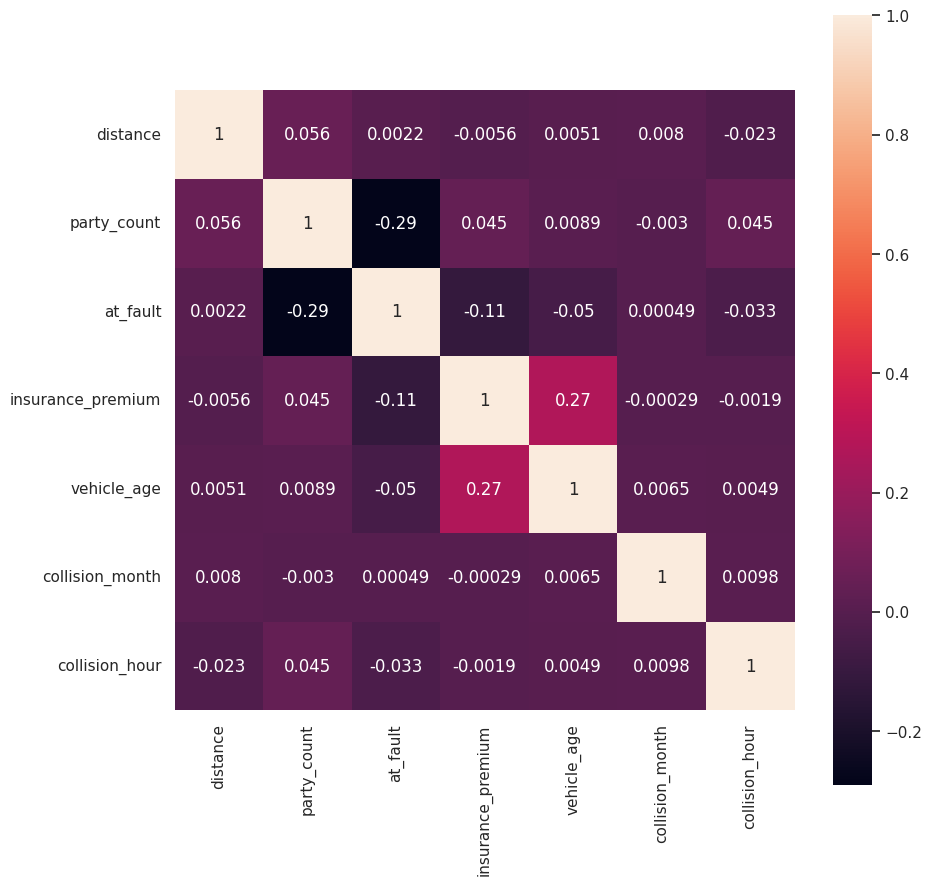

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(data.corr(), annot=True, ax=ax, square=True)

Существует незначительная орицательная корреляция между фичами at_fault и party_count, и положительная между vehicle_age и insurance_premium.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117898 entries, 0 to 117897
Data columns (total 27 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   county_location              117898 non-null  object 
 1   distance                     117898 non-null  float64
 2   direction                    117898 non-null  object 
 3   intersection                 117898 non-null  object 
 4   weather                      117898 non-null  object 
 5   location_type                117898 non-null  object 
 6   collision_damage             117898 non-null  object 
 7   party_count                  117898 non-null  int64  
 8   primary_collision_factor     117898 non-null  object 
 9   pcf_violation_category       117898 non-null  object 
 10  type_of_collision            117898 non-null  object 
 11  motor_vehicle_involved_with  117898 non-null  object 
 12  road_surface                 117898 non-null  object 
 13 

Напишем функцию для предобработки тестовых данных.

In [ ]:
def test_data_preprocessing(df):
  df = df.drop(columns=['county_city_location', 'case_id', 'id_parties', 'id_vehicles', 'party_number'], axis=1)
  df = df.rename(columns={'weather_1': 'weather', 'road_condition_1': 'road_condition'})

  df = df.drop_duplicates(ignore_index=True)

  for col in df.columns:
    if col == 'collision_date' or col == 'collision_time':
      df[col] = df[col].fillna(df[col].mode()[0])
    elif df[col].dtypes == 'object' or col == 'intersection':
      df[col] = df[col].fillna('unknown')
    elif df[col].dtypes == 'int' or df[col].dtypes == 'float':
      df[col] = df[col].fillna(df[col].median())

  df['intersection'] = df['intersection'].astype('object')

  df['collision_date'] = pd.to_datetime(df['collision_date'], format='%Y-%m-%d')
  df['collision_time'] = pd.to_datetime(df['collision_time'], format='%H:%M:%S')

  df['collision_month'] = df['collision_date'].dt.month
  df['collision_hour'] = df['collision_time'].dt.hour

  df = df.drop(columns=['collision_date', 'collision_time'], axis=1)

  df['insurance_premium'] = df['insurance_premium'].astype('int')
  df['cellphone_in_use'] = df['cellphone_in_use'].astype('string').astype('object')
  df['vehicle_age'] = df['vehicle_age'].astype('int')

  df.loc[~df['county_location'].isin(top_30_locations), 'county_location'] = 'other'
  df.loc[~df['weather'].isin(top_3_weather), 'weather'] = 'other'
  df.loc[~df['pcf_violation_category'].isin(top_10_pcf_violation_category), 'pcf_violation_category'] = 'other'
  df.loc[~df['motor_vehicle_involved_with'].isin(top_5_motor_vehicle_involved_with), 'motor_vehicle_involved_with'] = 'other'
  df.loc[~df['road_surface'].isin(top_2_road_surface), 'road_surface'] = 'other'
  df.loc[df['road_condition'] != 'normal', 'road_condition'] = 'other'
  df.loc[~df['control_device'].isin(top_2_control_device), 'control_device'] = 'other'
  df.loc[df['party_type'] != 'car', 'party_type'] = 'other'
  df.loc[~df['party_sobriety'].isin(top_4_party_sobriety), 'party_sobriety'] = 'other'
  df.loc[~df['party_drug_physical'].isin(top_3_party_drug_physical), 'party_drug_physical'] = 'other'
  df.loc[~df['vehicle_type'].isin(top_3_vehicle_type), 'vehicle_type'] = 'other'

  return df


In [ ]:
data_test = test_data_preprocessing(data_test)

In [ ]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39583 entries, 0 to 39582
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   county_location              39583 non-null  object 
 1   distance                     39583 non-null  float64
 2   direction                    39583 non-null  object 
 3   intersection                 39583 non-null  object 
 4   weather                      39583 non-null  object 
 5   location_type                39583 non-null  object 
 6   collision_damage             39583 non-null  object 
 7   party_count                  39583 non-null  int64  
 8   primary_collision_factor     39583 non-null  object 
 9   pcf_violation_category       39583 non-null  object 
 10  type_of_collision            39583 non-null  object 
 11  motor_vehicle_involved_with  39583 non-null  object 
 12  road_surface                 39583 non-null  object 
 13  road_condition  

## Обучение моделей.

В качестве метрики возьмем F1-score.

Не будем выделять валидационную выборку, потому что будем использовать кросс-валидацию.

Попробуем обучить модели случайного леса, градиентного бустинга и полносвязную нейронную сеть, подобрав для нее наилучшую архитектуру.

In [ ]:
x_train = data.drop(columns='at_fault', axis=1)
y_train = data['at_fault']

x_test = data_test.drop(columns='at_fault', axis=1)
y_test = data_test['at_fault']

In [ ]:
x_train.shape, y_train.shape

((117898, 26), (117898,))

In [ ]:
x_test.shape, y_test.shape

((39583, 26), (39583,))

Для обучения моделей применим технику one hot encoding.

In [ ]:
cat_features = ['county_location', 'direction', 'intersection', 'weather', 'location_type', 'collision_damage', 'primary_collision_factor', 'pcf_violation_category', 'type_of_collision', 'motor_vehicle_involved_with', 'road_surface', 'road_condition', 'lighting', 'control_device', 'party_type', 'party_sobriety', 'party_drug_physical', 'cellphone_in_use', 'vehicle_type', 'vehicle_transmission']
num_features = ['distance', 'party_count', 'insurance_premium', 'vehicle_age', 'collision_month', 'collision_hour']

In [ ]:
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

In [ ]:
x_train_ohe = pd.DataFrame(ohe.fit_transform(x_train[cat_features]), columns=ohe.get_feature_names_out())
x_train_ohe[num_features] = x_train[num_features]

Первой обученной моделью будет случайный лес.

In [ ]:
def objective(trial):
  params = {"max_depth": trial.suggest_int("max_depth", 6, 20),
             'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
             'n_estimators': trial.suggest_int('n_estimators', 10, 1600, log=True),
             'min_samples_split': trial.suggest_int('min_samples_split', 2, 10)
            }
  model = RandomForestClassifier(**params, class_weight='balanced', random_state=987)
  return cross_val_score(model, x_train_ohe, y_train, cv=3, scoring='f1').mean()

In [ ]:
sampler = optuna.samplers.TPESampler(seed=987)
study = optuna.create_study(direction='maximize', sampler=sampler)
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=10)

[I 2023-12-18 06:22:38,001] A new study created in memory with name: no-name-e40157b3-86b8-4021-a913-29f21e14f80d


In [ ]:
print('best_params: ', study.best_params)

best_params:  {'max_depth': 19, 'min_samples_leaf': 5, 'n_estimators': 1093, 'min_samples_split': 5}


In [ ]:
best_model = RandomForestClassifier(**study.best_params, class_weight='balanced', random_state=987)

In [ ]:
best_model.fit(x_train_ohe, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=19,
                       min_samples_leaf=5, min_samples_split=5,
                       n_estimators=1093, random_state=987)

Проверим работу модели на тестовой выборке. Применим к ней OHE.

In [ ]:
x_test_ohe = pd.DataFrame(ohe.transform(x_test[cat_features]), columns=ohe.get_feature_names_out())
x_test_ohe[num_features] = x_test[num_features]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2, 8, 12] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
pred = best_model.predict(x_test_ohe)
f1 = f1_score(y_test, pred)
print('F1 score:', f1)

F1 score: 0.7036600442770478


На тестовой выборке случайный лес показывает довольно хороший скор f1 = 0.7

Теперь обучим модель градиентного бустинга.

Для градиентного бустинга подойдет метод порядкового кодирования.

In [ ]:
ord_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)


In [ ]:
x_train_ord = pd.DataFrame(ord_enc.fit_transform(x_train[cat_features]), columns=cat_features)
x_train_ord[num_features] = x_train[num_features]

In [ ]:
cat_boost = CatBoostClassifier(verbose=250, random_state=987)

In [ ]:
print("\n\nF1 score:", abs(cross_val_score(cat_boost, x_train_ord, y_train, cv=3, scoring='f1').mean()))

Learning rate set to 0.066416
0:	learn: 0.6414058	total: 91.7ms	remaining: 1m 31s
250:	learn: 0.4564892	total: 7.08s	remaining: 21.1s
500:	learn: 0.4445262	total: 12.2s	remaining: 12.1s
750:	learn: 0.4348163	total: 20.1s	remaining: 6.65s
999:	learn: 0.4264911	total: 25.2s	remaining: 0us
Learning rate set to 0.066417
0:	learn: 0.6422507	total: 24ms	remaining: 24s
250:	learn: 0.4564417	total: 6.62s	remaining: 19.8s
500:	learn: 0.4442328	total: 13s	remaining: 12.9s
750:	learn: 0.4347704	total: 18.1s	remaining: 5.99s
999:	learn: 0.4262272	total: 26s	remaining: 0us
Learning rate set to 0.066417
0:	learn: 0.6427724	total: 19.1ms	remaining: 19s
250:	learn: 0.4553341	total: 5.07s	remaining: 15.1s
500:	learn: 0.4430519	total: 12.8s	remaining: 12.8s
750:	learn: 0.4334598	total: 18s	remaining: 5.98s
999:	learn: 0.4251113	total: 23.6s	remaining: 0us


F1 score: 0.7107479754121065


На кросс-валидации модель показала скор 0.71.

Проверим ее на тестовой выборке.

In [ ]:
cat_boost = CatBoostClassifier(verbose=250, random_state=987)

In [ ]:
cat_boost.fit(x_train_ord, y_train)

Learning rate set to 0.078971
0:	learn: 0.6331318	total: 55.5ms	remaining: 55.4s
250:	learn: 0.4564407	total: 9.41s	remaining: 28.1s
500:	learn: 0.4468440	total: 19.4s	remaining: 19.4s
750:	learn: 0.4392360	total: 27s	remaining: 8.96s
999:	learn: 0.4330074	total: 36.9s	remaining: 0us


Применим к тестовой выборке порядковое кодирование.

In [ ]:
x_test_ord = pd.DataFrame(ord_enc.transform(x_test[cat_features]), columns=cat_features)
x_test_ord[num_features] = x_test[num_features]

In [ ]:
pred = cat_boost.predict(x_test_ord)
f1 = f1_score(pred, y_test)
print('F1 score:', f1)

F1 score: 0.7275292113598254


На тестовой выборке бустинг показывает себя еще лучше, выдавая скор F1 = 0.727.

Попробуем протюнить параметры модели с помощью библиотеки optuna.

In [ ]:
def objective(trial):
  params = {"learning_rate": trial.suggest_float("learning_rate", 0.05, 0.35),
             'max_depth': trial.suggest_int('max_depth', 3, 15),
             'n_estimators': trial.suggest_int('n_estimators', 100, 500)
            }
  model = CatBoostClassifier(**params, verbose=250, random_state=987)
  return abs(cross_val_score(model, x_train_ord, y_train, cv=3, scoring='f1')).mean()

In [ ]:
sampler = optuna.samplers.TPESampler(seed=987)
study = optuna.create_study(direction='maximize', sampler=sampler)
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=10)

0:	learn: 0.5822422	total: 26.9ms	remaining: 12.1s
250:	learn: 0.4072558	total: 6.67s	remaining: 5.34s
451:	learn: 0.3716254	total: 15.3s	remaining: 0us
0:	learn: 0.5889222	total: 26ms	remaining: 11.7s
250:	learn: 0.4068272	total: 6.6s	remaining: 5.28s
451:	learn: 0.3718167	total: 14.8s	remaining: 0us
0:	learn: 0.5877796	total: 24.9ms	remaining: 11.3s
250:	learn: 0.4049471	total: 6.35s	remaining: 5.09s
451:	learn: 0.3713117	total: 14.4s	remaining: 0us
0:	learn: 0.5741145	total: 137ms	remaining: 1m 4s
250:	learn: 0.1746604	total: 1m 38s	remaining: 1m 25s
467:	learn: 0.1031299	total: 3m 1s	remaining: 0us
0:	learn: 0.5790492	total: 50.7ms	remaining: 23.7s
250:	learn: 0.1813326	total: 1m 33s	remaining: 1m 20s
467:	learn: 0.1047138	total: 3m 5s	remaining: 0us
0:	learn: 0.5776935	total: 108ms	remaining: 50.5s
250:	learn: 0.1789766	total: 1m 34s	remaining: 1m 21s
467:	learn: 0.1053803	total: 2m 52s	remaining: 0us
0:	learn: 0.5297794	total: 120ms	remaining: 13.3s
111:	learn: 0.1670269	total: 1

In [ ]:
print('best params:', study.best_params)

best params: {'learning_rate': 0.17179073787474697, 'max_depth': 8, 'n_estimators': 452}


Проверим модель с лучшими параметрами на тестовой выборке.

In [ ]:
best_model = CatBoostClassifier(**study.best_params, verbose=250, random_state=987)

In [ ]:
best_model.fit(x_train_ord, y_train)

0:	learn: 0.5829660	total: 30.8ms	remaining: 13.9s
250:	learn: 0.4226646	total: 11.1s	remaining: 8.92s
451:	learn: 0.3966787	total: 18.2s	remaining: 0us


In [ ]:
pred = best_model.predict(x_test_ord)
f1 = f1_score(y_test, pred)
print('F1 score:', f1)

F1 score: 0.7202042535270583


Оптимизация параметров не дала результатов.

Теперь попытаемся подобрать наилушую архитектуру для нейронной сети.

Для нейронной сети стандартизируем обе выборки.

In [ ]:
st_scaler = StandardScaler()

In [ ]:
x_train_ohe_st = pd.DataFrame(st_scaler.fit_transform(x_train_ohe), columns=x_train_ohe.columns)
x_train = x_train_ohe_st

In [ ]:
x_test_ohe_st = pd.DataFrame(st_scaler.transform(x_test_ohe), columns=x_test_ohe.columns)
x_test = x_test_ohe_st

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

In [ ]:
x_train = torch.FloatTensor(x_train_ohe_st.values)
y_train = torch.FloatTensor(y_train.values).reshape(y_train.shape[0], 1)

x_test = torch.FloatTensor(x_test_ohe_st.values)
y_test = torch.FloatTensor(y_test.values).reshape(y_test.shape[0], 1)

In [ ]:
x_train = x_train.to(device)
y_train = y_train.to(device)

x_test = x_test.to(device)
y_test = y_test.to(device)

In [ ]:
n_in_neurons = x_train.shape[1]
n_out_neurons = 1

In [ ]:
f1 = F1Score(task='binary').to(device)
loss = nn.BCELoss()

Подберем количество нейронов для сети с тремя скрытыми слоями. Используем дропаут.

In [ ]:
samples = 10
h1 = list(range(200, 801, 50))
h2 = list(range(200, 801, 50))
h3 = list(range(200, 801, 50))

In [ ]:
for _ in range(samples):
  n_hidden_neurons_1 = h1[np.random.randint(0, len(h1))]
  n_hidden_neurons_2 = h2[np.random.randint(0, len(h2))]
  n_hidden_neurons_3 = h3[np.random.randint(0, len(h3))]

  net = nn.Sequential(
      nn.Linear(n_in_neurons, n_hidden_neurons_1),
      nn.Tanh(),
      nn.Dropout(p=0.5),
      nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
      nn.Tanh(),
      nn.Dropout(p=0.5),
      nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3),
      nn.Tanh(),
      nn.Dropout(p=0.5),
      nn.Linear(n_hidden_neurons_3, n_out_neurons),
      nn.Sigmoid()
  )

  net = net.to(device)

  optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

  num_epochs = 1000

  for epoch in range(num_epochs):

    optimizer.zero_grad()

    preds = net.forward(x_train)

    loss_value = loss(preds, y_train)
    loss_value.backward()

    optimizer.step()

  net.eval()
  f1_sc = f1(net.forward(x_test), y_test)
  print('h1:', n_hidden_neurons_1, 'h2:', n_hidden_neurons_2, 'h3:', n_hidden_neurons_3, 'f1:', f1_sc)

h1: 350 h2: 550 h3: 650 f1: tensor(0.7318, device='cuda:0')
h1: 500 h2: 350 h3: 500 f1: tensor(0.7313, device='cuda:0')
h1: 700 h2: 450 h3: 700 f1: tensor(0.7309, device='cuda:0')
h1: 350 h2: 700 h3: 800 f1: tensor(0.7292, device='cuda:0')
h1: 300 h2: 800 h3: 350 f1: tensor(0.7297, device='cuda:0')
h1: 650 h2: 350 h3: 700 f1: tensor(0.7278, device='cuda:0')
h1: 200 h2: 700 h3: 500 f1: tensor(0.7288, device='cuda:0')
h1: 250 h2: 250 h3: 700 f1: tensor(0.7303, device='cuda:0')
h1: 650 h2: 600 h3: 750 f1: tensor(0.7325, device='cuda:0')
h1: 500 h2: 700 h3: 650 f1: tensor(0.7303, device='cuda:0')


Лучшего результата добилась сеть с 650, 600 и 750 нейронами в скрытых слоях.

Нейронная сеть показала себя лучше, чем другие модели. F1 = 0.7325

**ВЫВОД**

**В ходе работы были проведены предобработка и исследовательский анализ данных. Были обучены и протестированы модели случайного леса, градиентного бустинга и нейронная сеть для решения задачи оценки риска ДТП по выбранному маршруту движения. Наилучшей моделью оказалась нейронная сеть, показав метрику F1 = 0.7325**